<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr

from sklearn.preprocessing import StandardScaler

from sklearn import model_selection;
from sklearn import metrics;
from sklearn.metrics import make_scorer;
from sklearn.dummy import DummyClassifier;
from sklearn.linear_model import LinearRegression, LassoCV, Ridge; 
from sklearn.feature_selection import SelectKBest, chi2, f_classif; 
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV;
from sklearn import linear_model;
from sklearn.svm import SVC;

import matplotlib;
import matplotlib.pyplot as plt;

import seaborn as sns;
import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['font.family'] = 'monospace';
matplotlib.rcParams['font.weight'] = 3;
matplotlib.rcParams['font.size'] = 10;

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## 1. Data Selection & Preprocessing

### 1.1 Wrangling 

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape

(1460, 81)

In [3]:
#Look at the features contained
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### Remove Non-Residential

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [4]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
r_zone = 'RH', 'RL', 'RP', 'RM'
house = house[house.MSZoning.isin(r_zone)]
house.MSZoning.value_counts()

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

In [6]:
house.shape

(1385, 81)

### 1.2 Eliminate with Threshold

#### Part 1 - Handle Null Values & Eliminate with Threshold

Approach: eliminate features with empty values > 70%.

Rationale: 70% is arbritrary, if the feature has that many values missing or 0s, it probably is not a very good predictor anyway

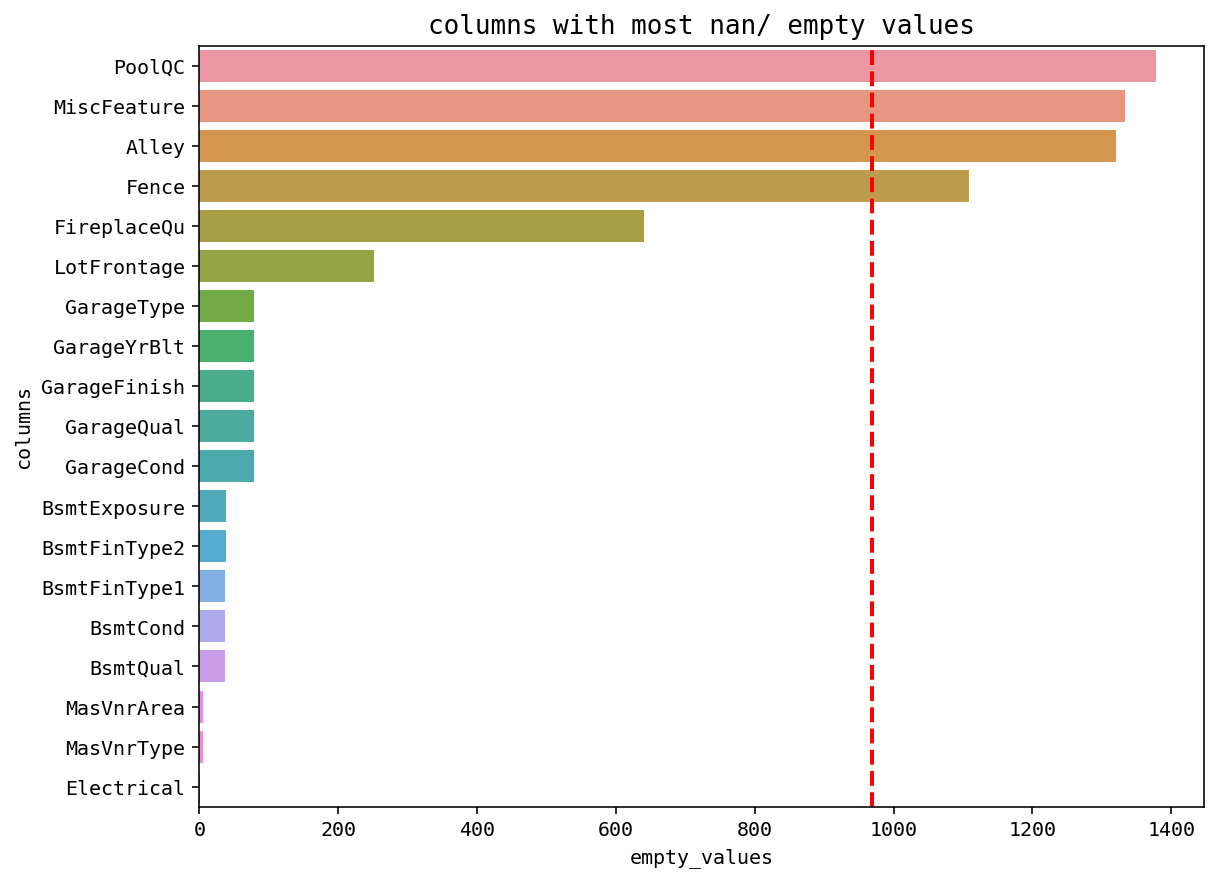

In [7]:
#Check for columns with nan/missing values
#Anything to the right of the vertical line can be eliminated

x = []

for c in house:
    x.append(c)
    y = house.isnull().sum()

zeroes = pd.DataFrame(x, y).reset_index()
zeroes.columns = ['empty_values', 'columns']
zeroes = zeroes[zeroes['empty_values'] > 0].sort_values(by='empty_values', ascending=False)

_ = plt.figure(figsize=(9,7))
_ = sns.barplot(zeroes['empty_values'], zeroes['columns'])
_ = plt.title('columns with most nan/ empty values', size =13)
_ = plt.axvline(x=.7*len(house), linestyle='--', color='r', linewidth=2)
plt.show()

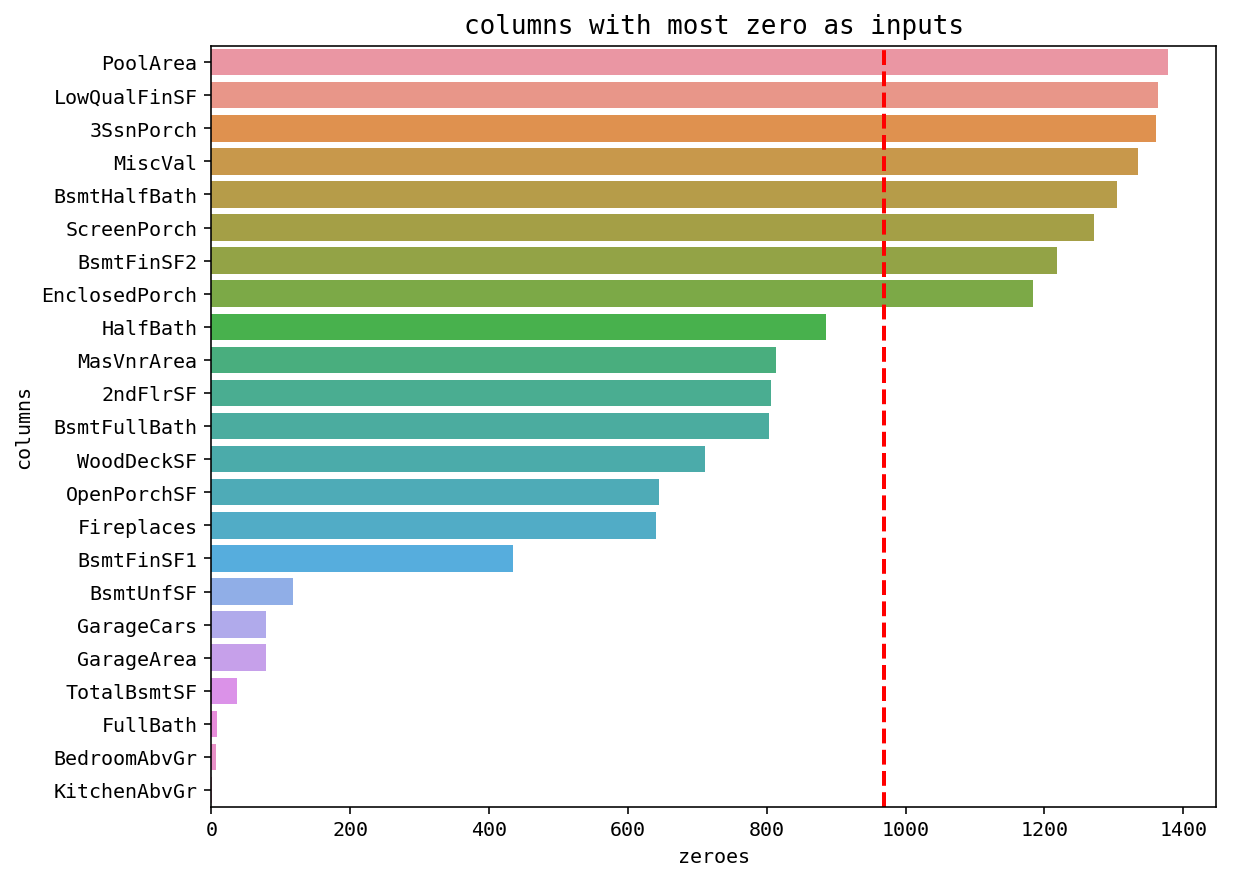

In [8]:
#Check for columns with plenty of zero inputs
#Anything to the right of the vertical line can be eliminated

x = []
y = []

for c in house.columns:
    x.append(c)
    y.append((house[c] == 0).sum())
    
zeroes = pd.DataFrame(x, y).reset_index()
zeroes.columns = ['zeroes', 'columns']
zeroes = zeroes[zeroes['zeroes'] > 0].sort_values(by='zeroes', ascending=False)

_ = plt.figure(figsize=(9,7))
_ = plt.title('columns with most zero as inputs', size =13)
_ = sns.barplot(zeroes['zeroes'], zeroes['columns'])
_ = plt.axvline(x=.7*len(house), linestyle='--', color='r', linewidth=2)
plt.show()

In [9]:
#Dropped them and narrowed down to 68 features
house = house.drop(['PoolArea', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'LowQualFinSF', '3SsnPorch', 'MiscVal',
                              'ScreenPorch', 'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch'], axis=1)
house.shape

(1385, 69)

In [10]:
#For the time being, let's fill the data with zeroes/ unknowns

def fill_na(df):
    for column in df.select_dtypes('object').columns :
        df[column] = df[column].fillna('Unknown')

    for column in df.select_dtypes(exclude=['object']):
        df[column] = df[column].fillna(0.)
        
fill_na(house)

In [11]:
#Set ID as Index so we can split and combine the dataset later
house.set_index('Id', inplace=True)

#### Part 2 - Trim Numerical Data & EDA

In [12]:
housenum = house.select_dtypes(exclude='object')
housenum.shape

(1385, 29)

In [13]:
#Correcting datatypes
house['MSSubClass'] = house.MSSubClass.astype('object')
housenum.drop('MSSubClass', axis=1, inplace=True)

In [14]:
#We can combine these! 
#Age of the house
housenum['Age'] = (housenum.YrSold + (housenum.MoSold)/12.) - housenum.YearBuilt
housenum['Age_Remodel'] = (housenum.YrSold + (housenum.MoSold)/12.) - housenum.YearRemodAdd
housenum.drop(['YearBuilt','YearRemodAdd'], axis=1, inplace=True)

In [15]:
#Basement
housenum.drop(['BsmtFinSF1','BsmtUnfSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

In [16]:
#Bathroom
housenum['BathAbvGr'] = housenum.FullBath + housenum.HalfBath
housenum.drop(['FullBath','HalfBath'], axis=1, inplace=True)

In [17]:
#Garage - we can drop either Garage Area or Garage Cars since they're very likely colinear 
housenum.drop('GarageCars', axis=1, inplace=True)

In [18]:
housenum.shape

(1385, 22)

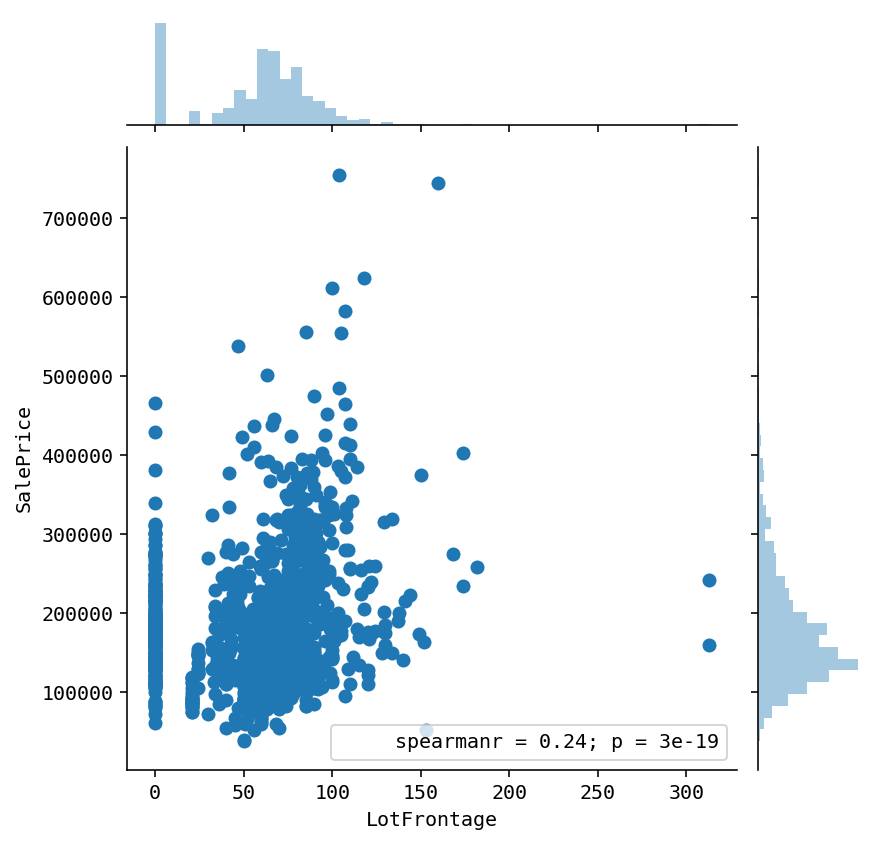

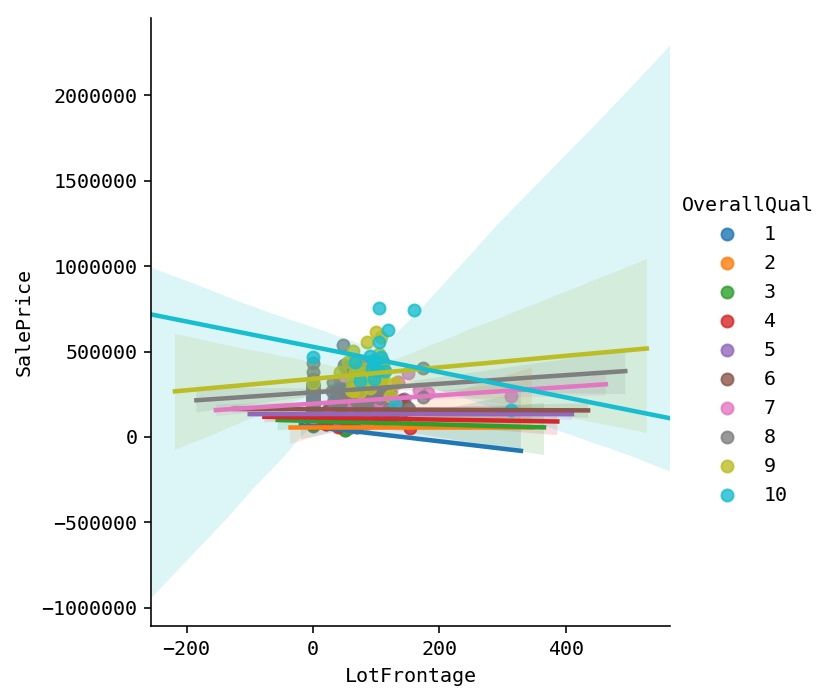

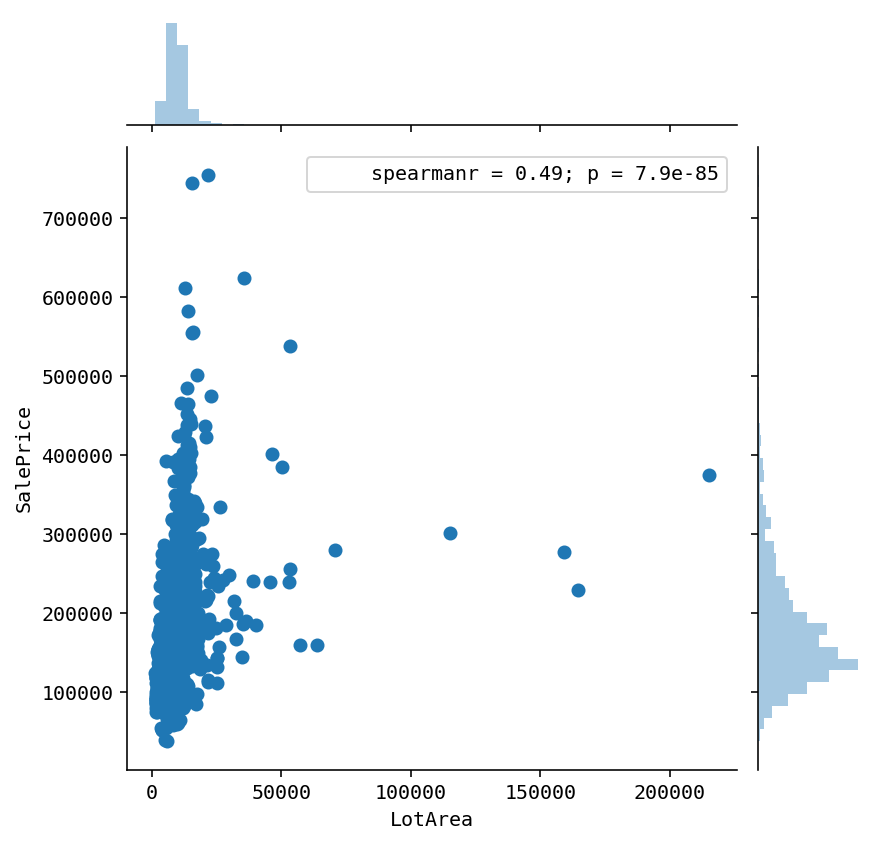

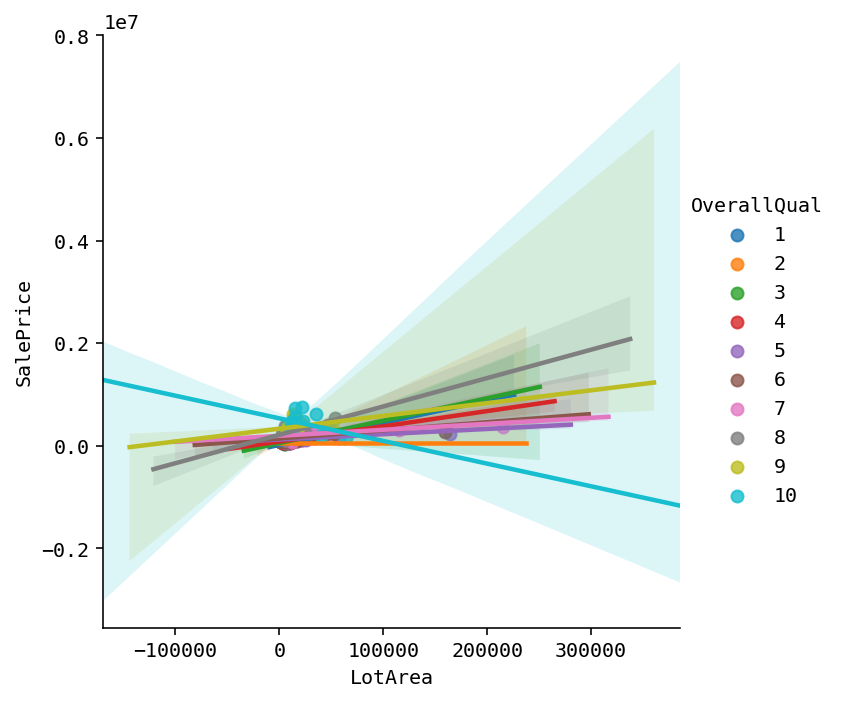

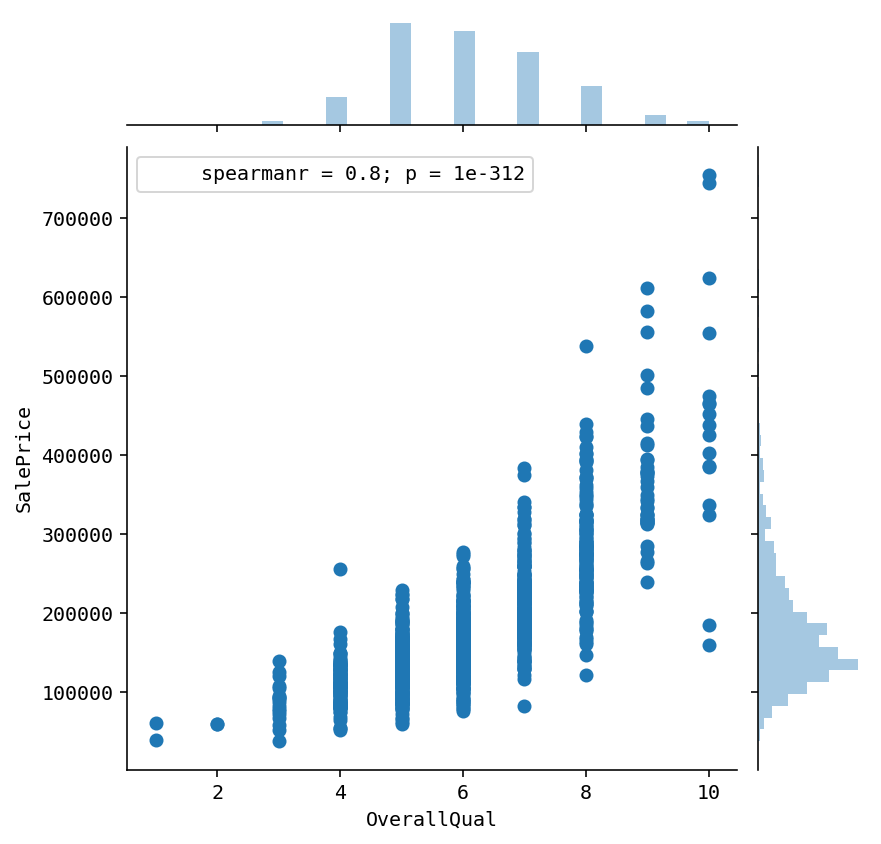

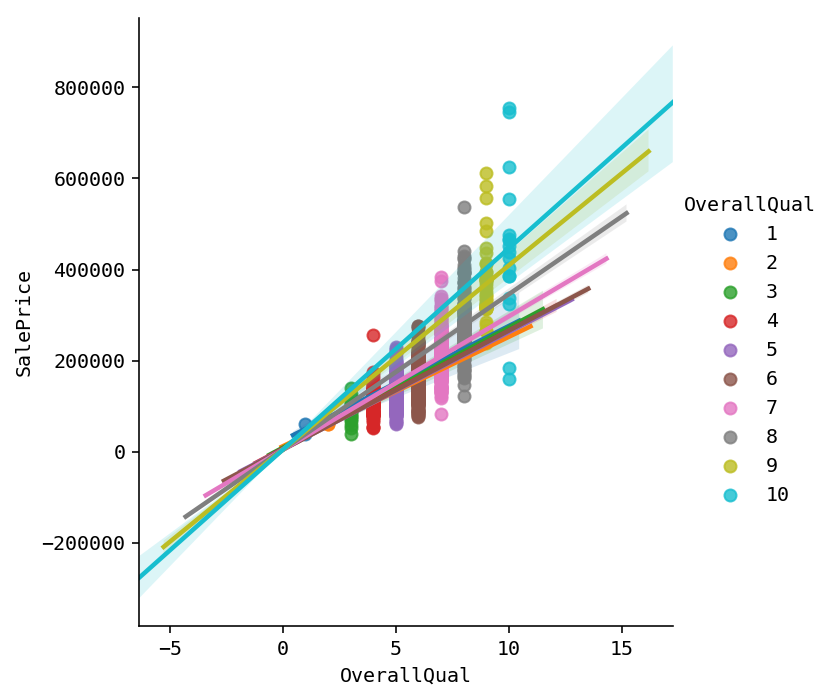

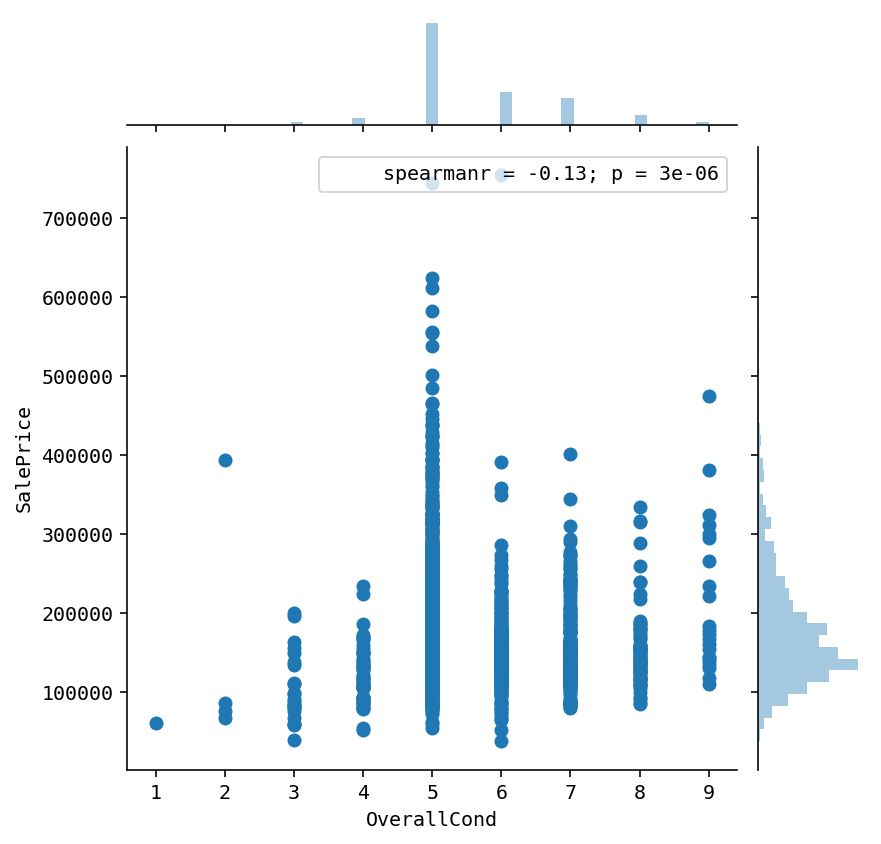

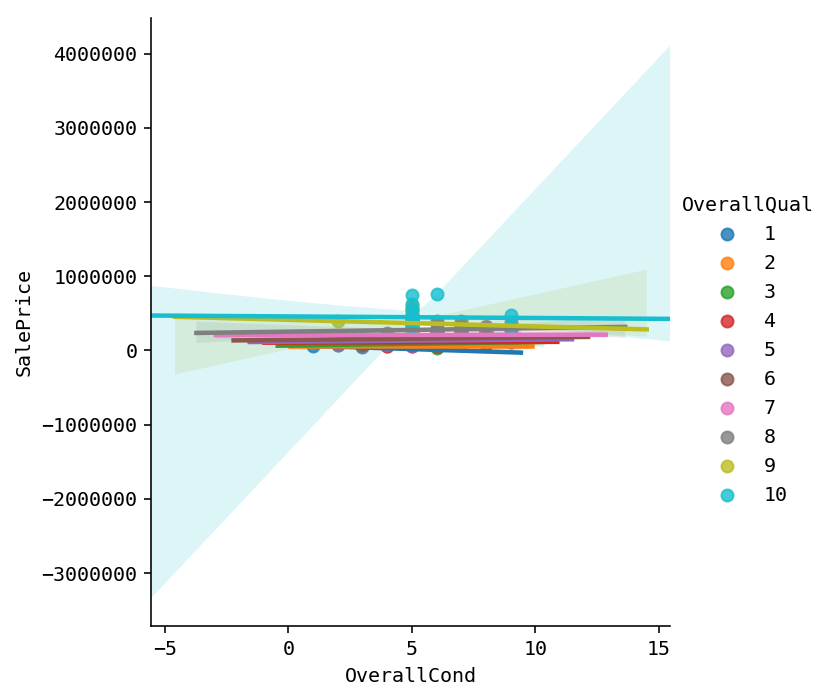

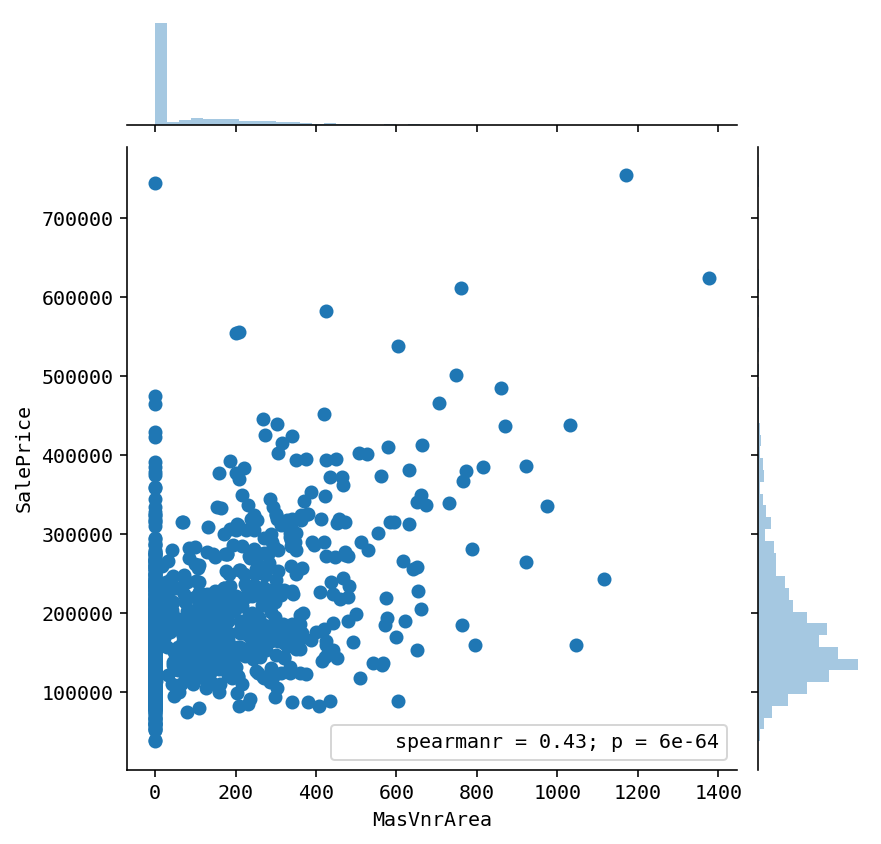

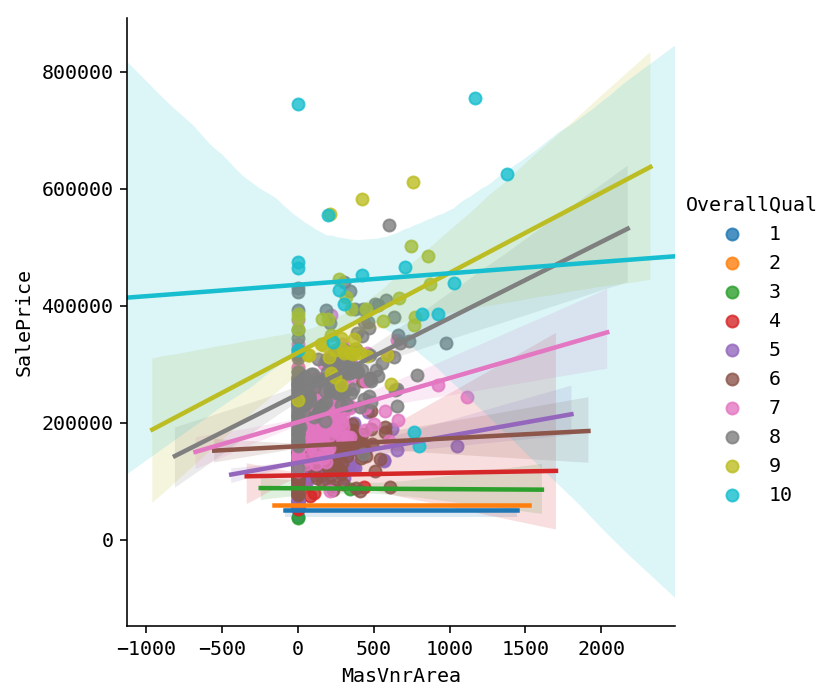

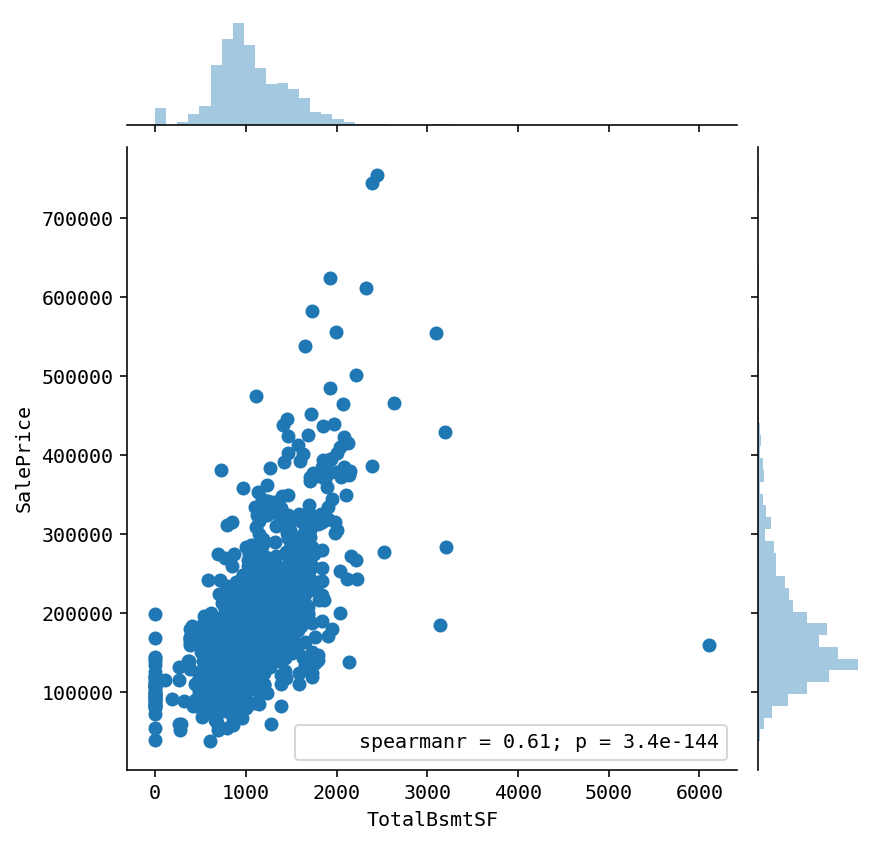

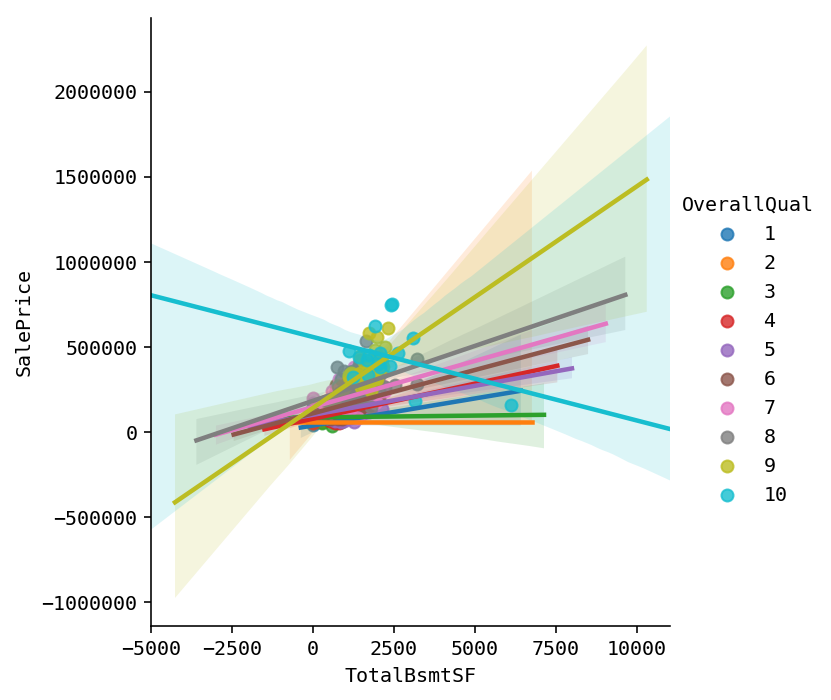

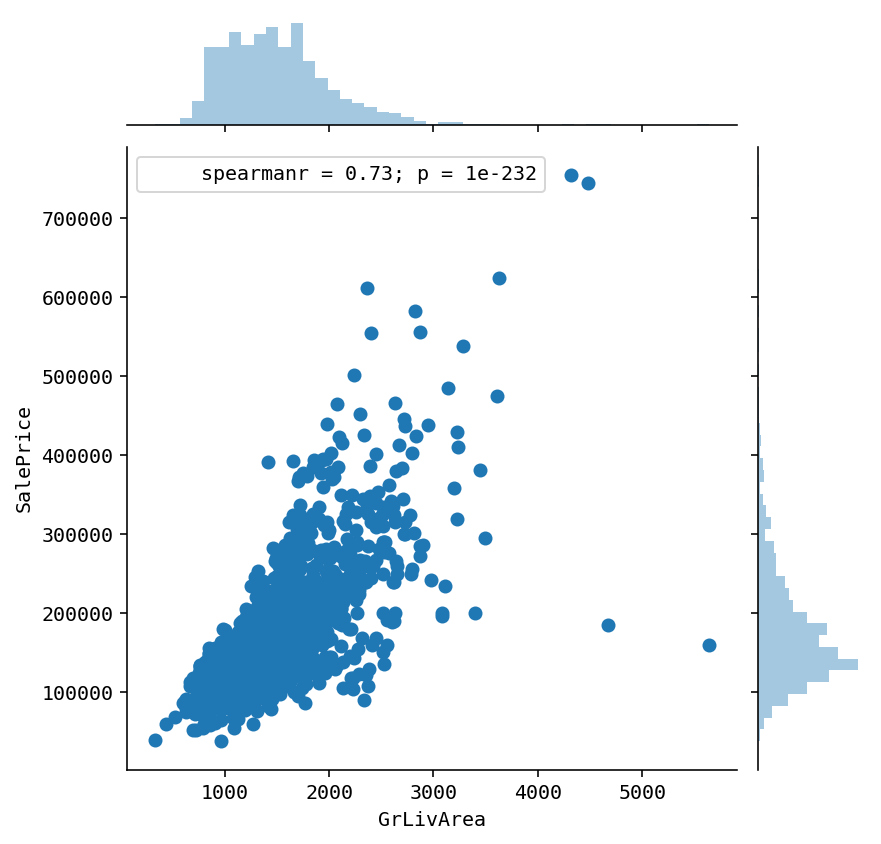

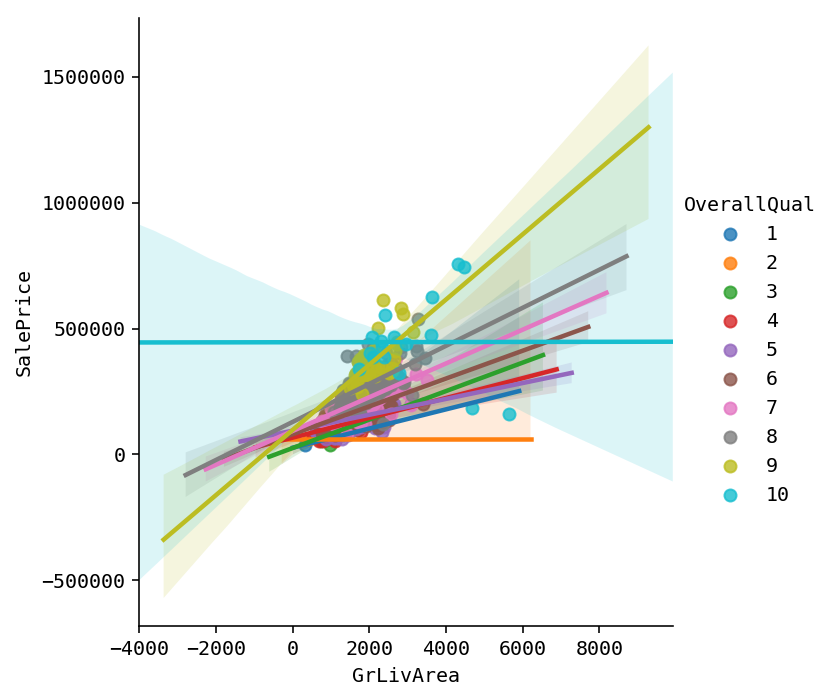

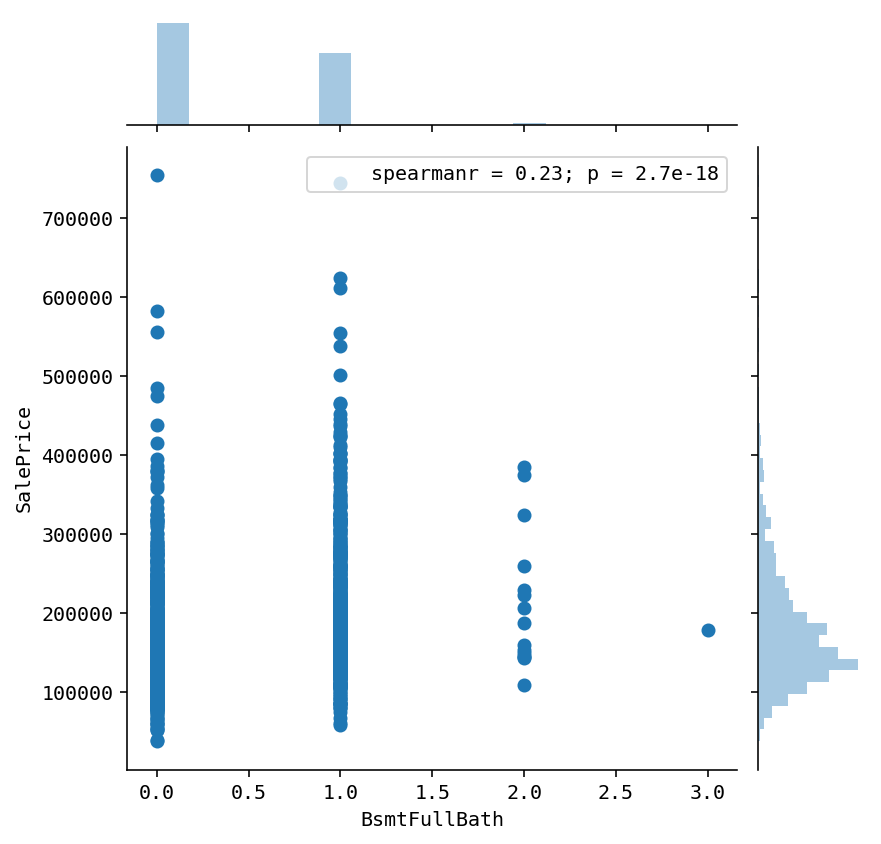

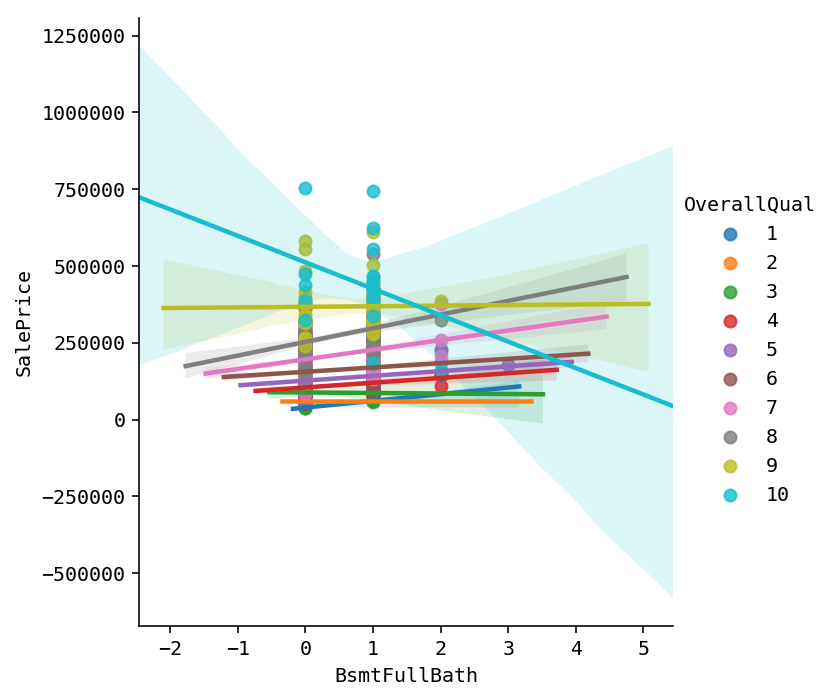

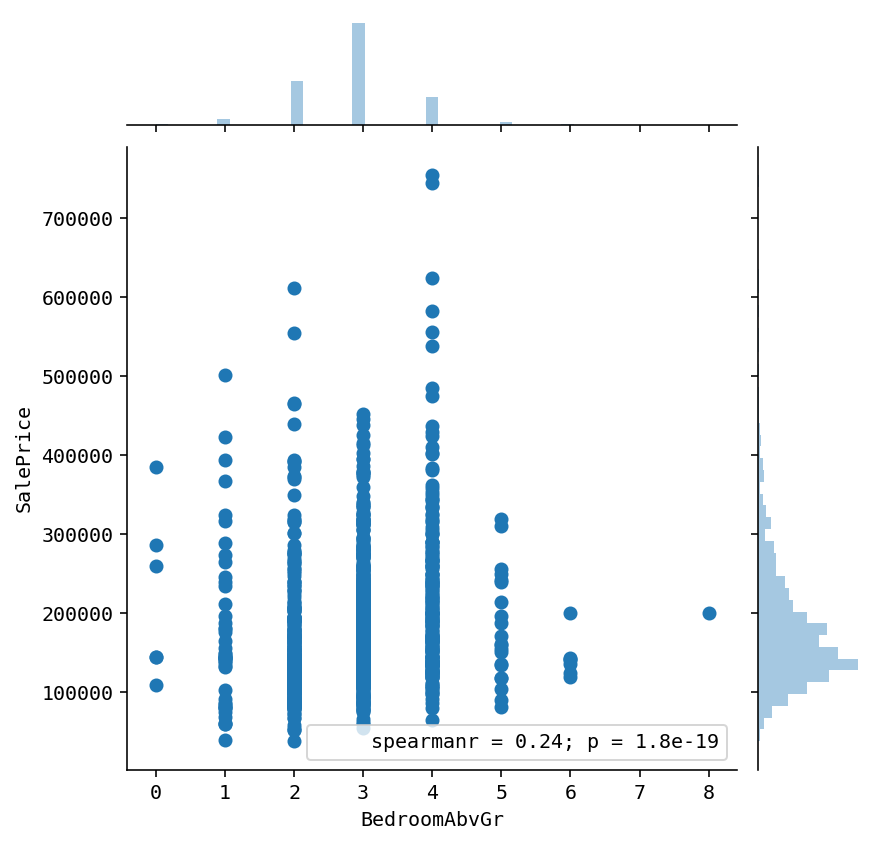

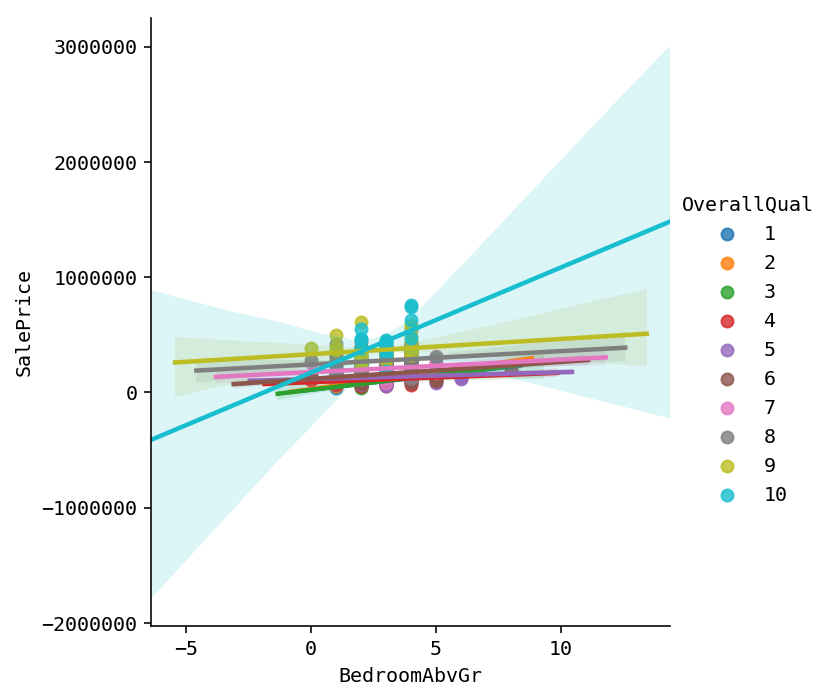

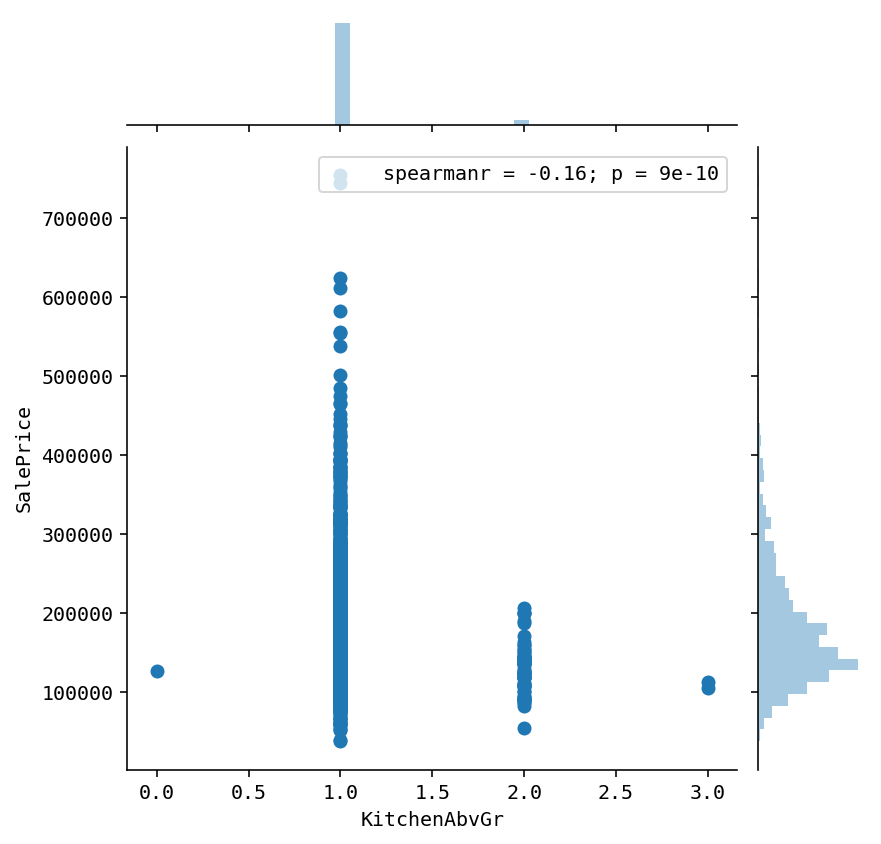

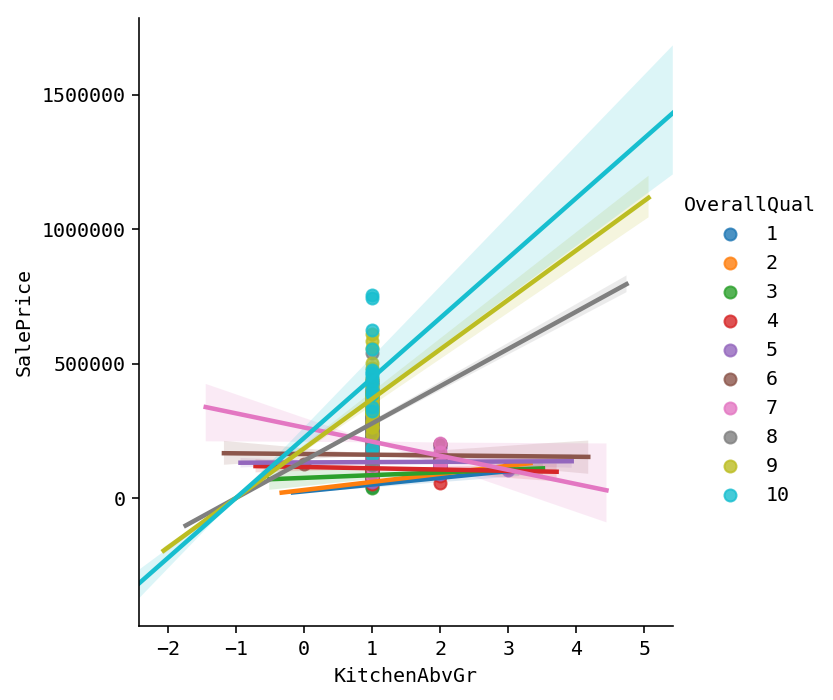

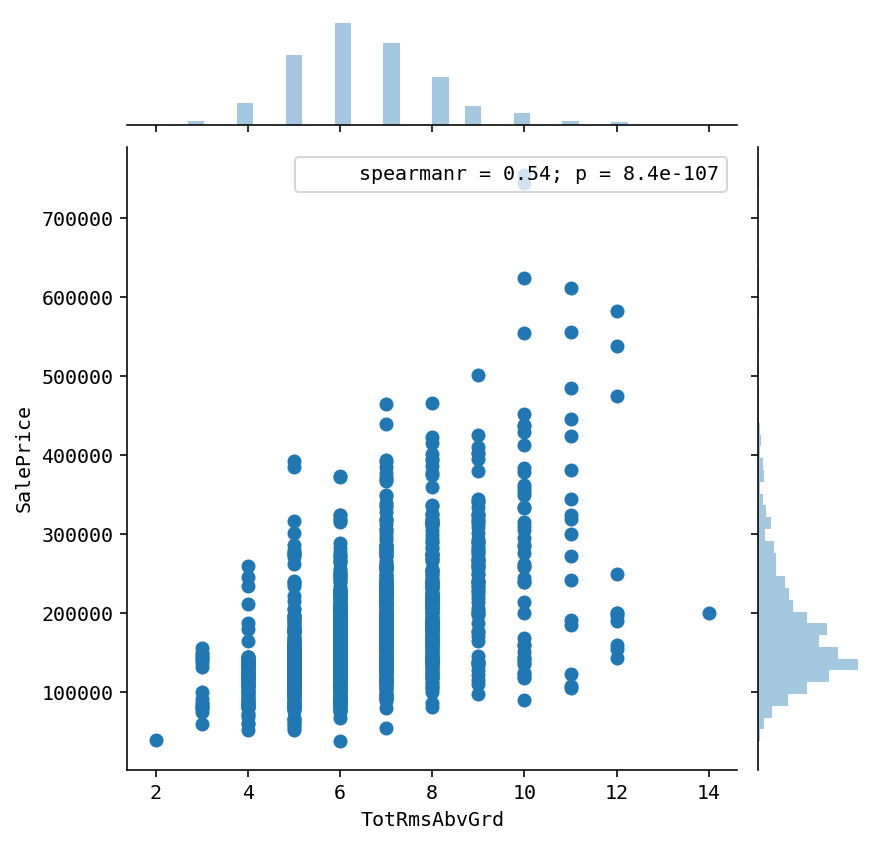

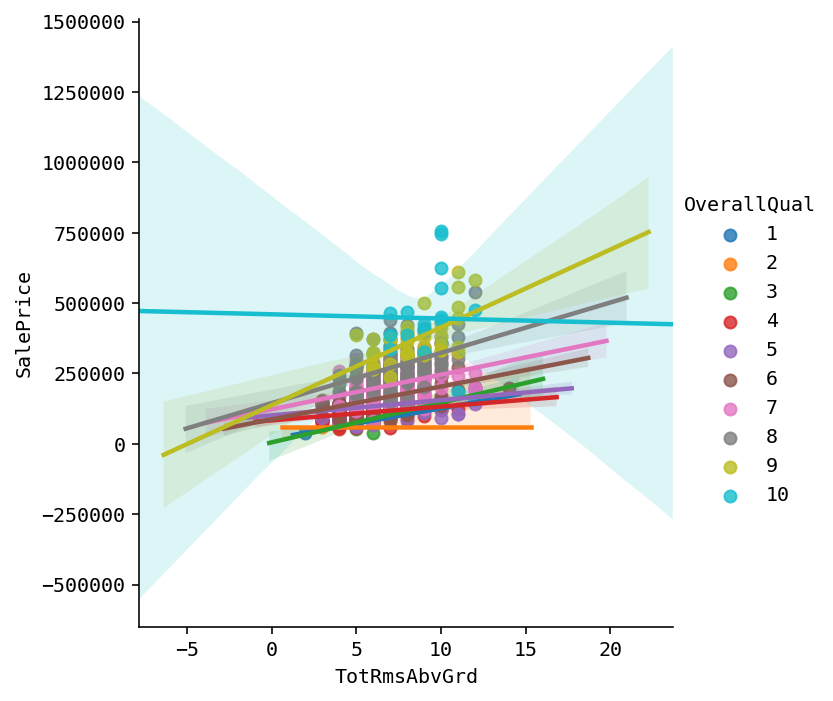

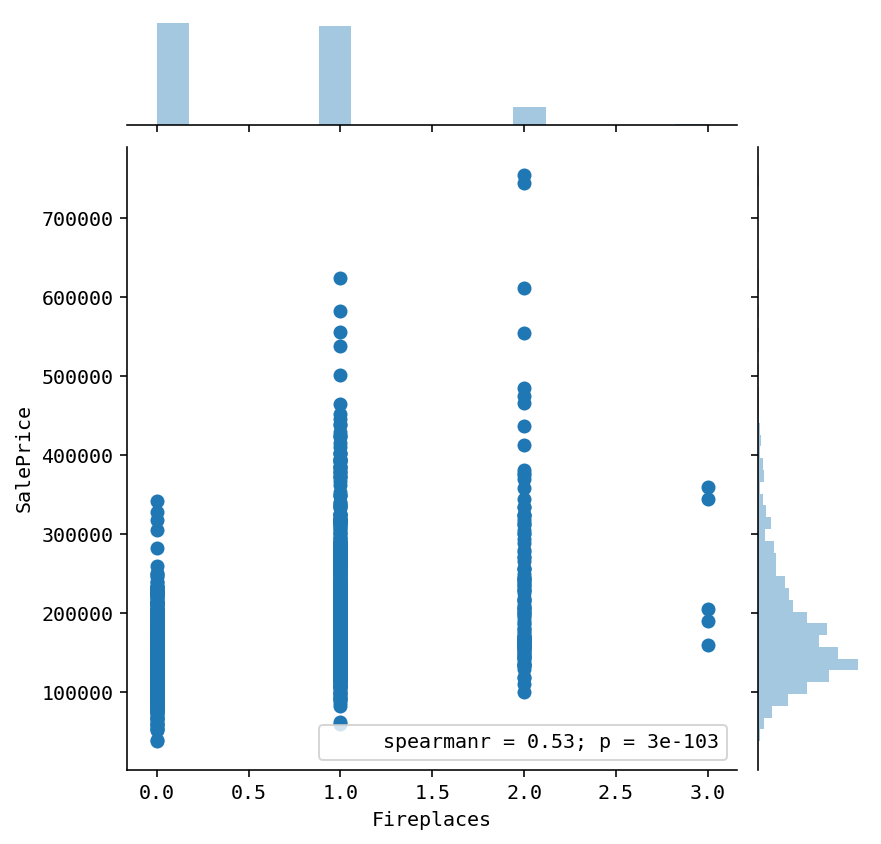

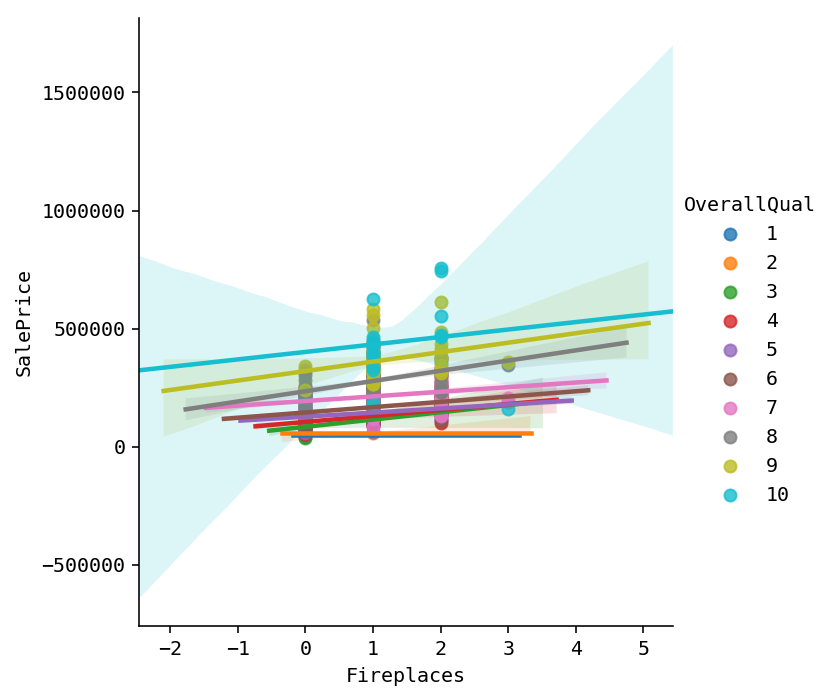

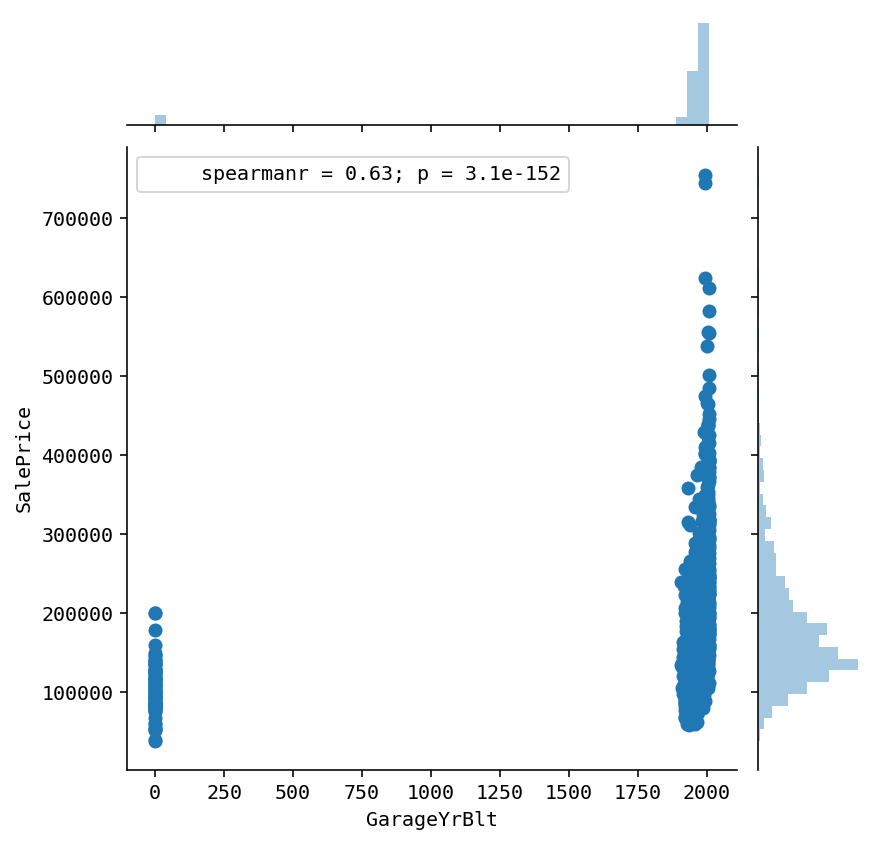

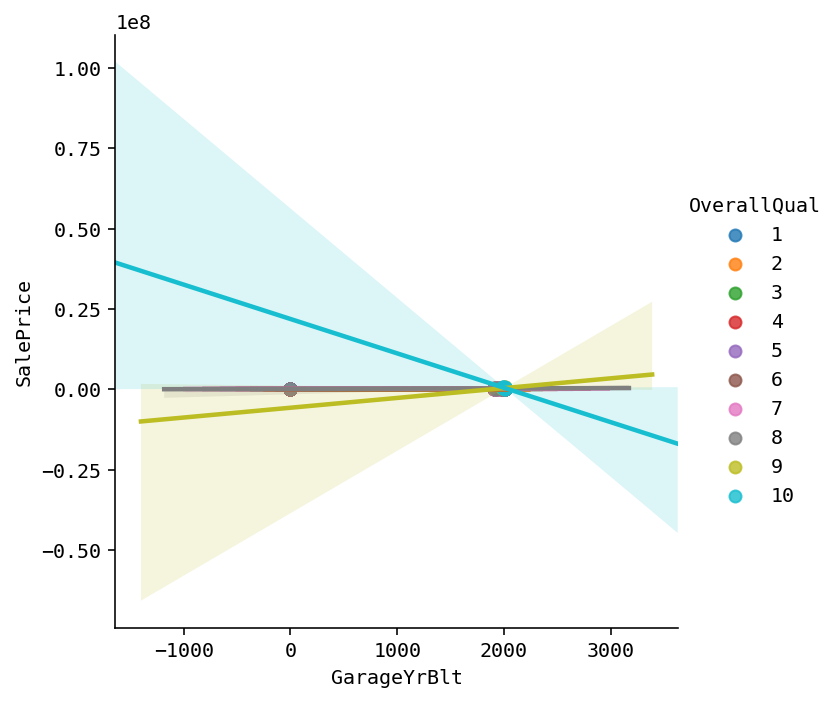

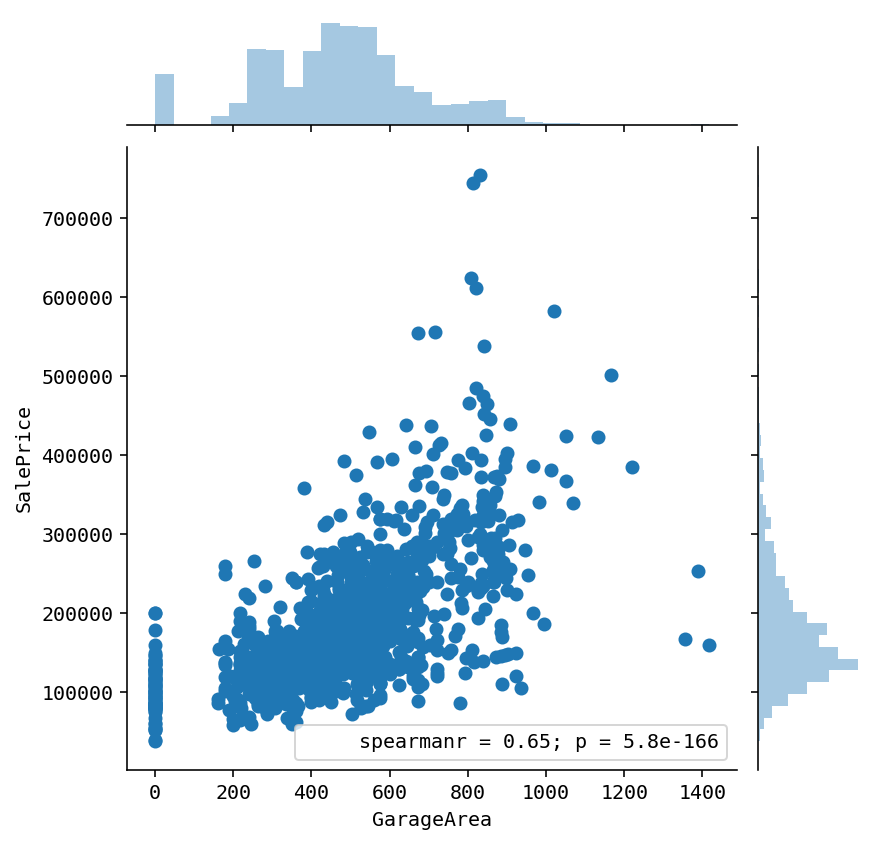

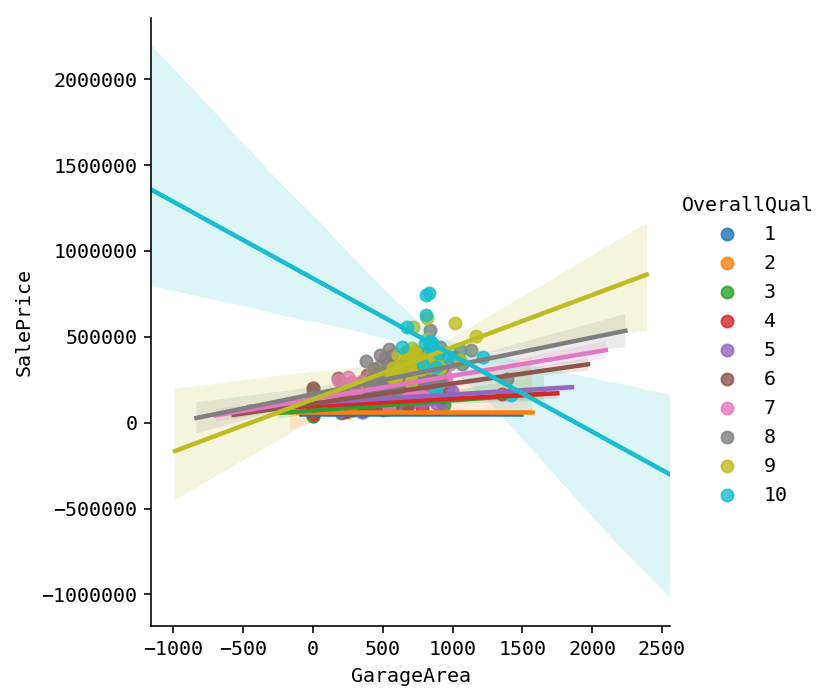

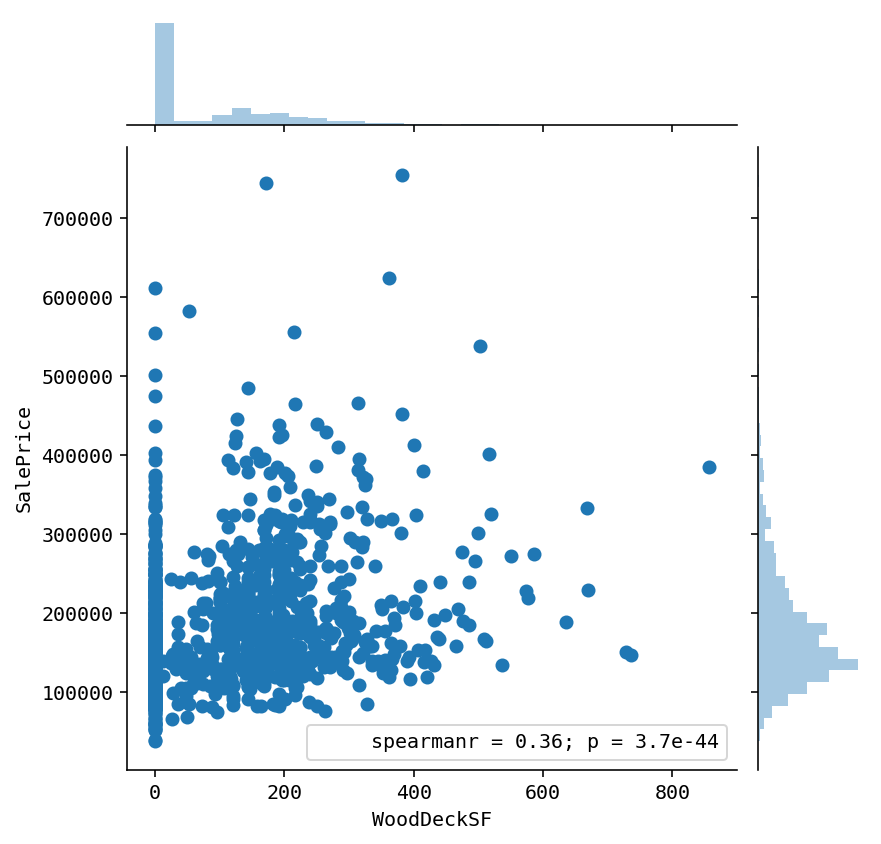

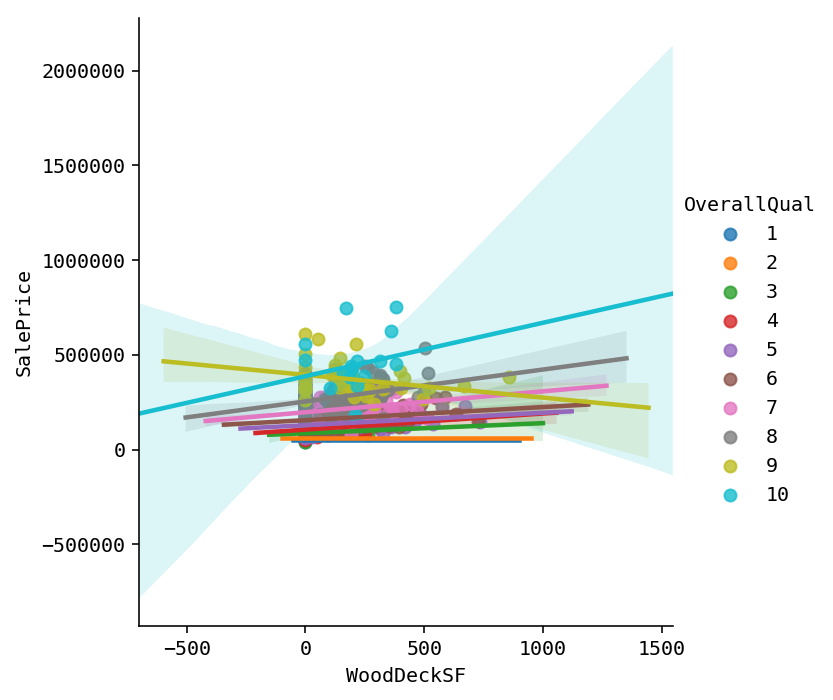

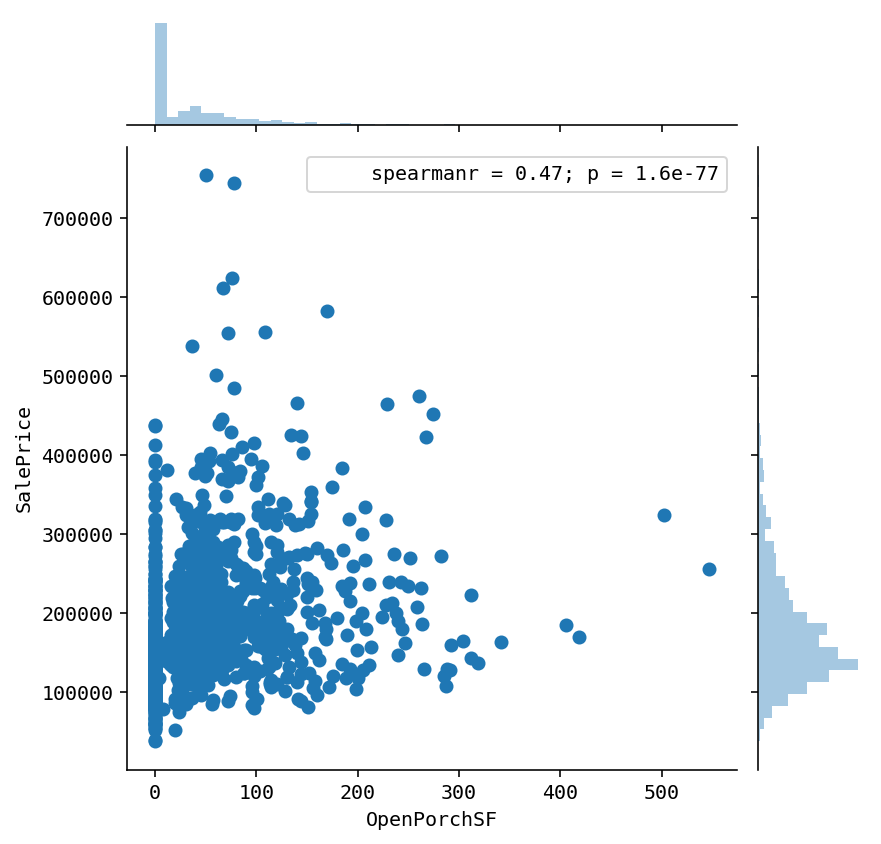

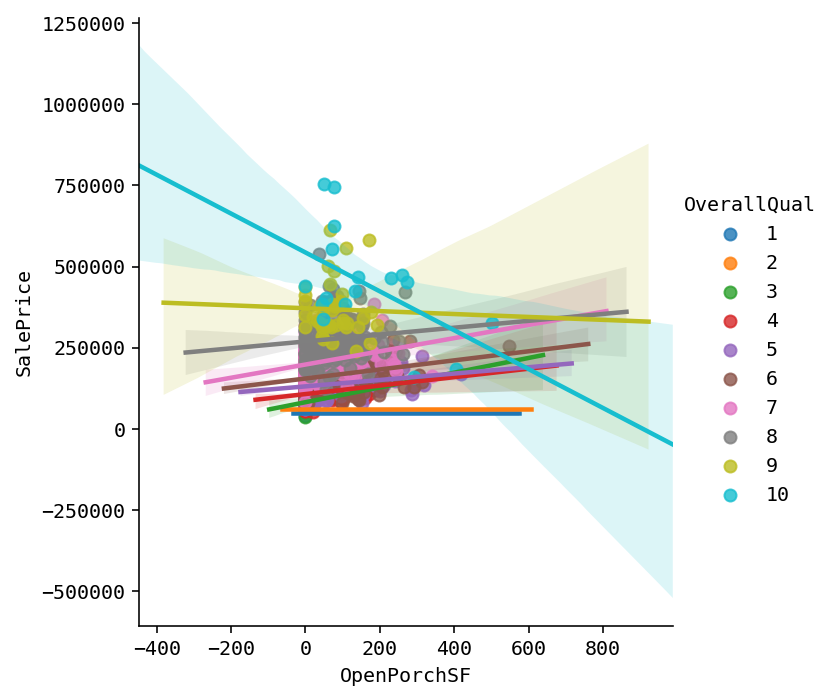

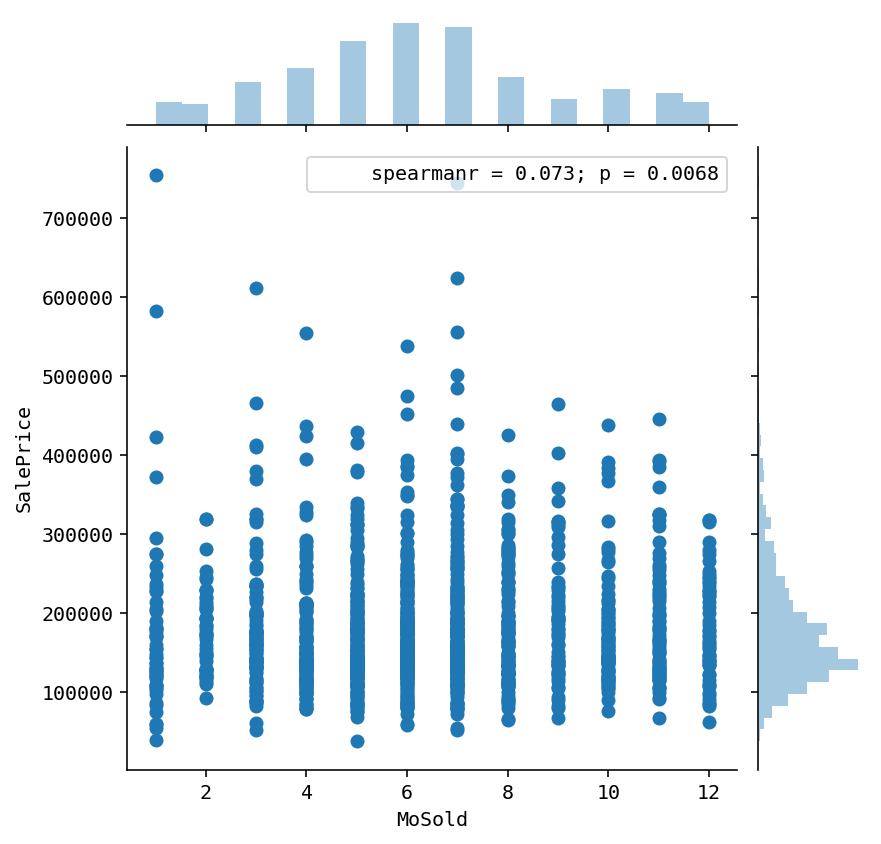

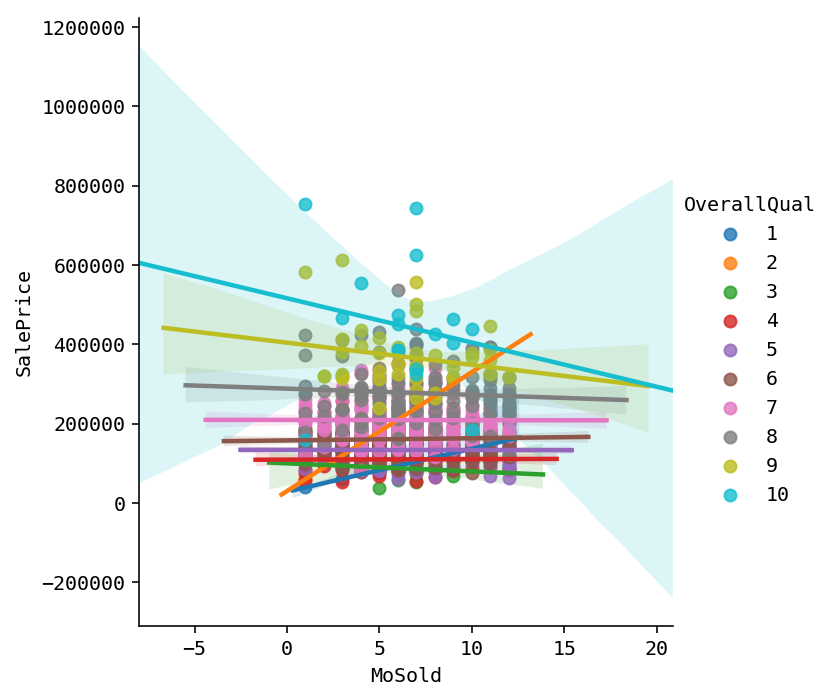

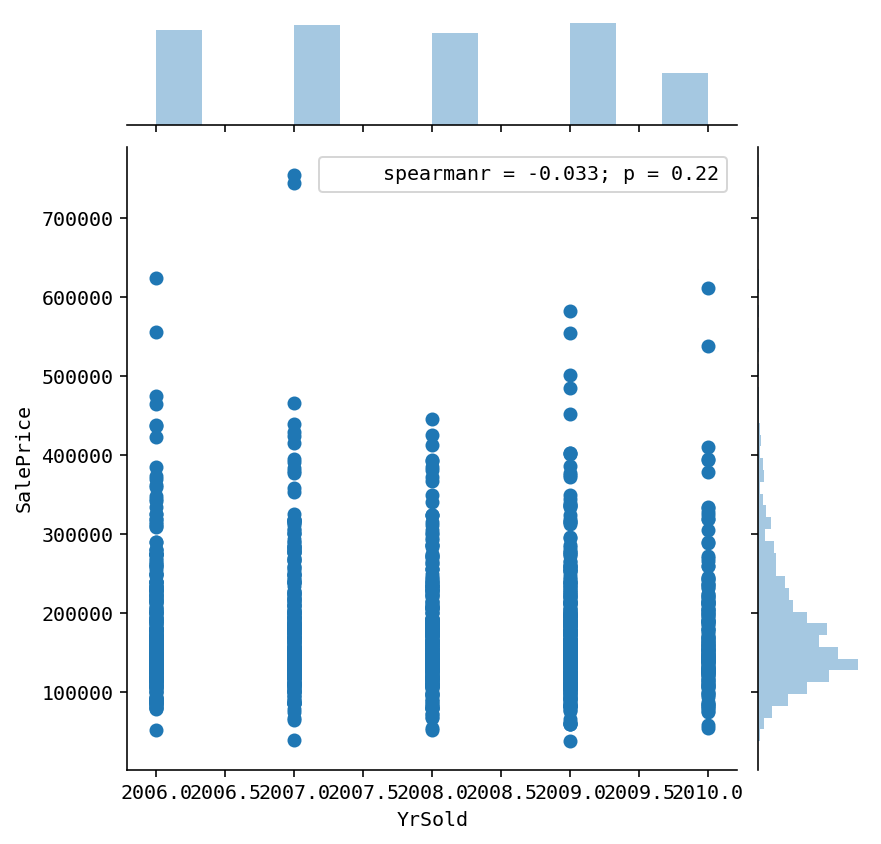

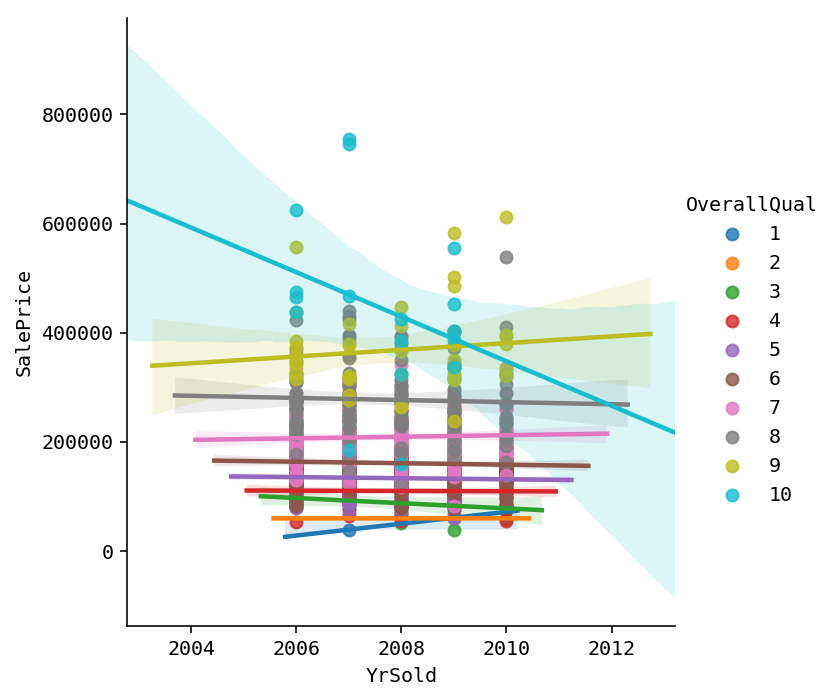

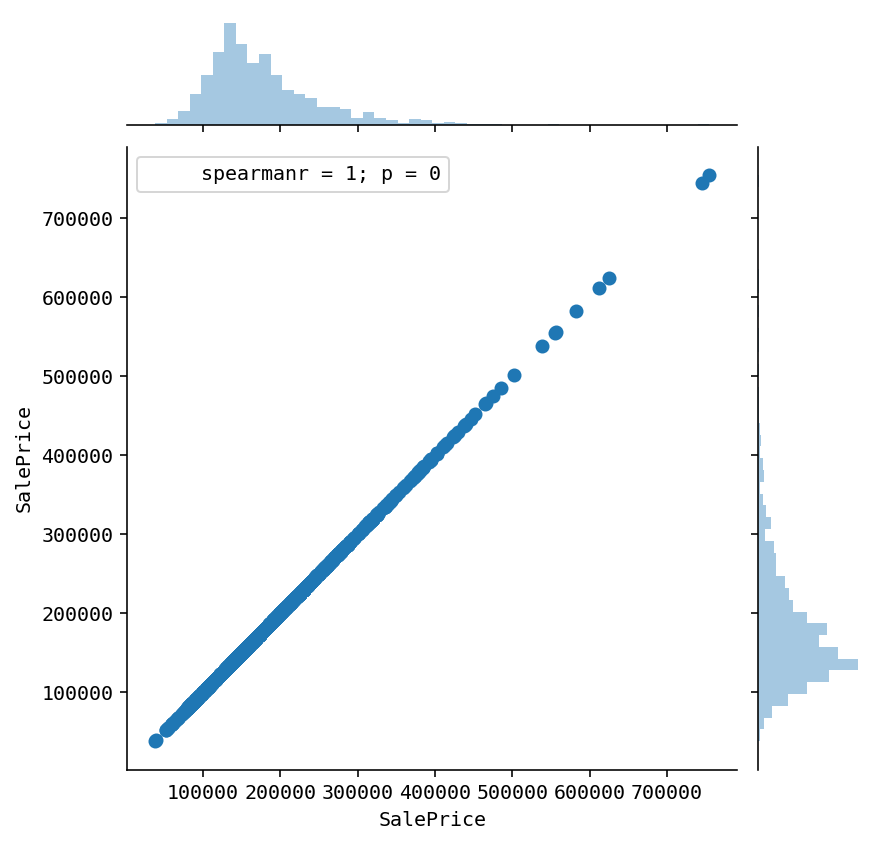

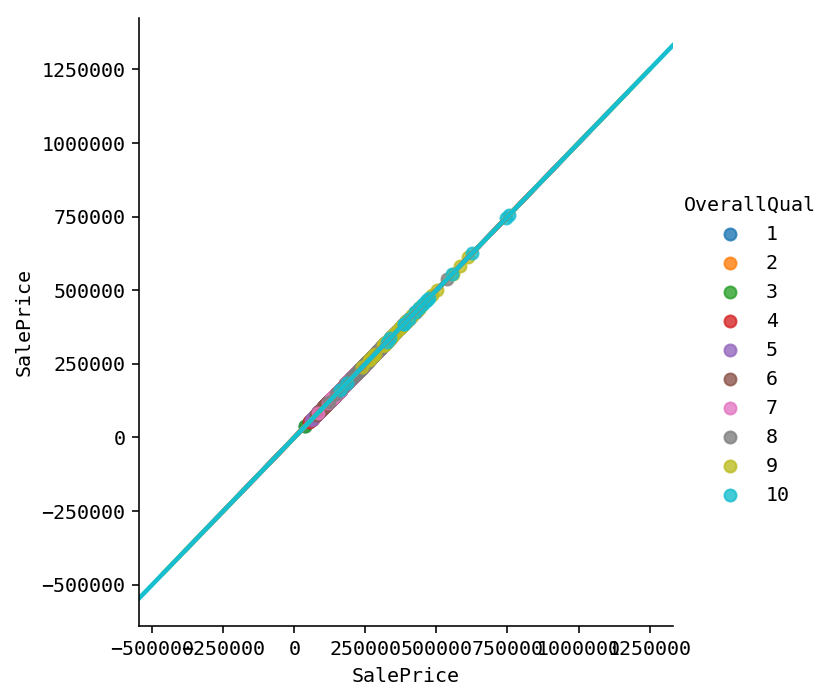

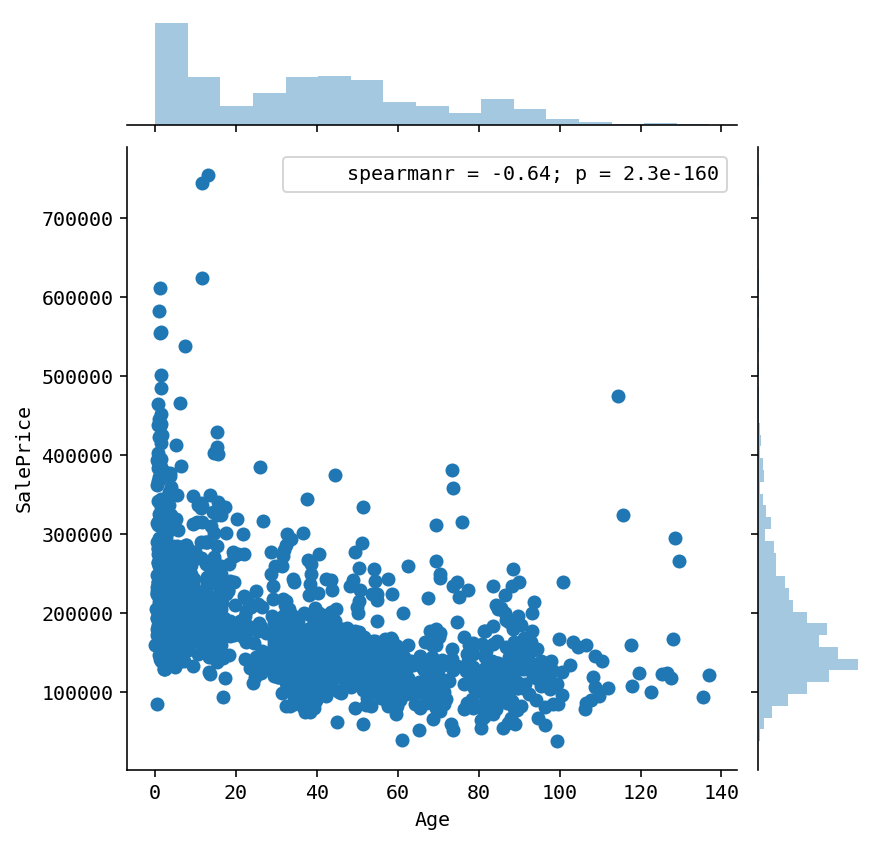

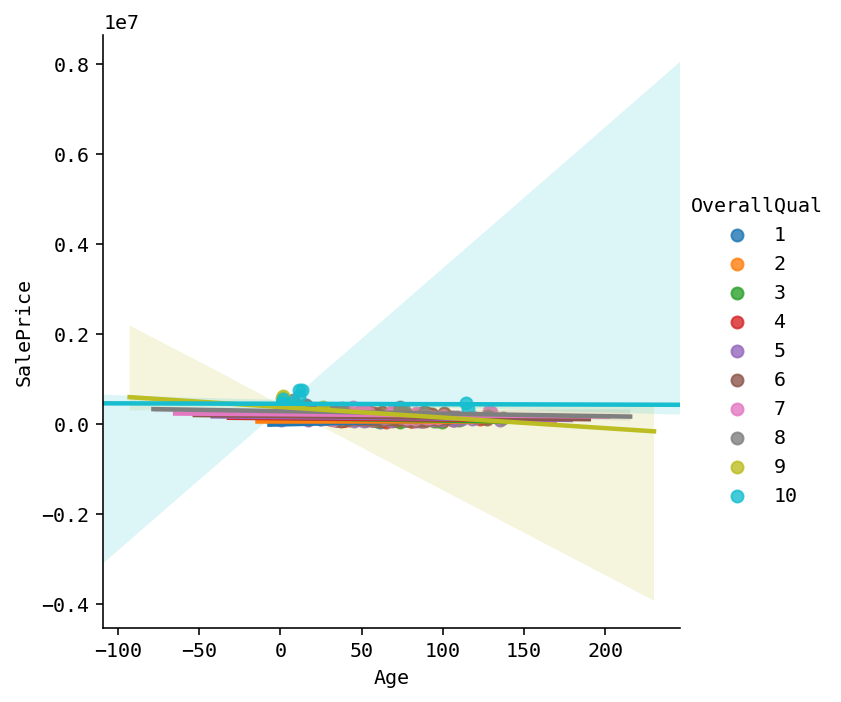

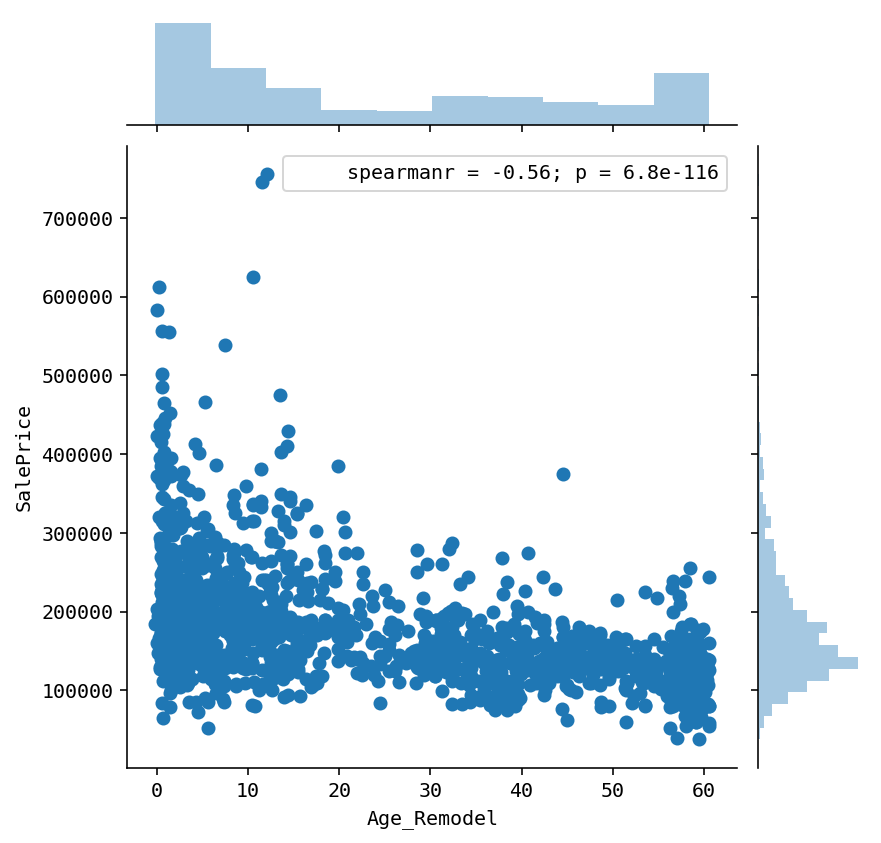

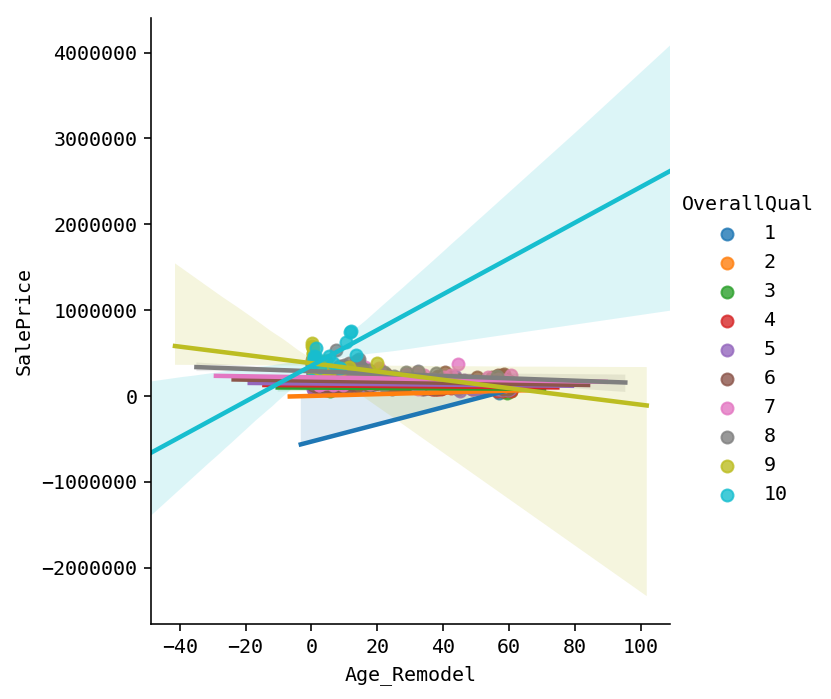

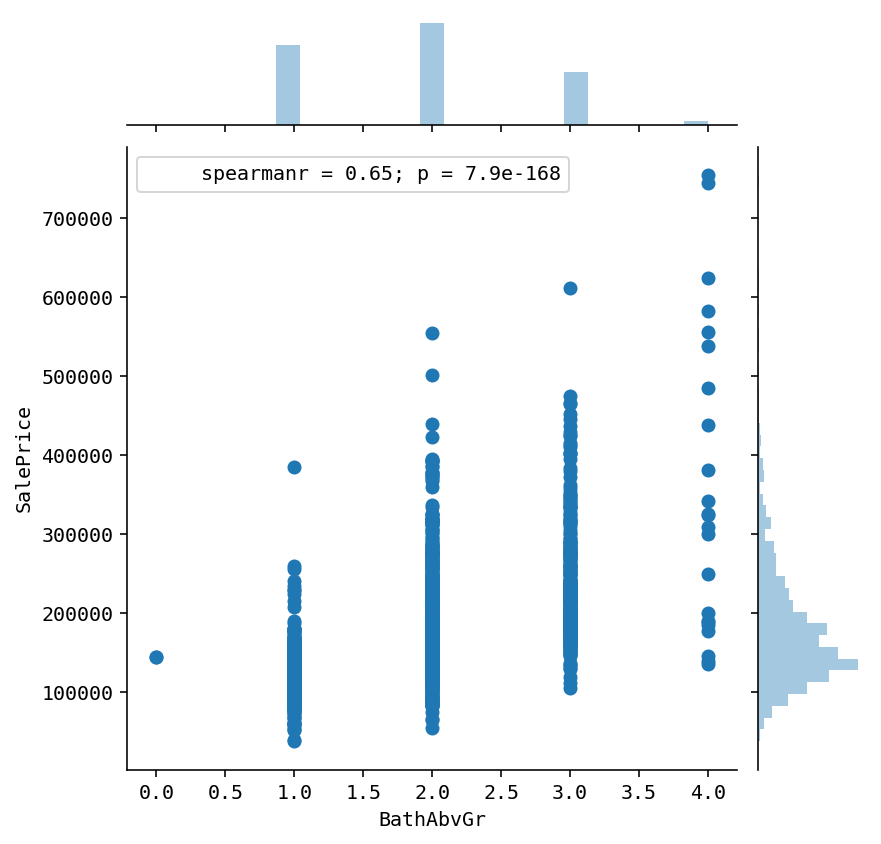

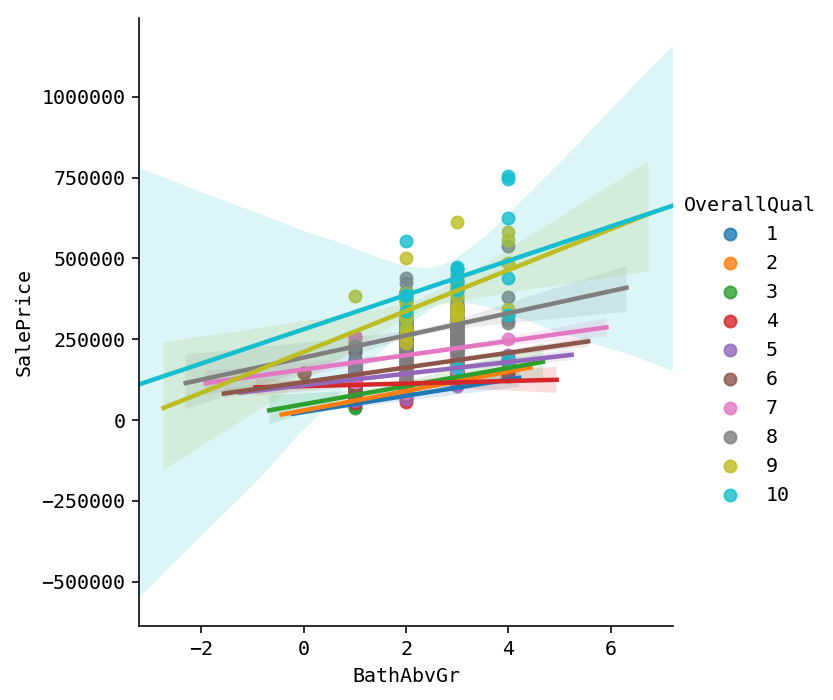

In [19]:
for feature in (housenum):
    #fig,axes = plt.subplots(nrows=1, ncols=2,figsize = (12,4))
    sns.jointplot(x=feature, y='SalePrice', data=housenum, stat_func=spearmanr)#, ax=axs[0]) 
    sns.lmplot(x=feature,y='SalePrice', hue='OverallQual', data=housenum)#, #ax=axs[1])

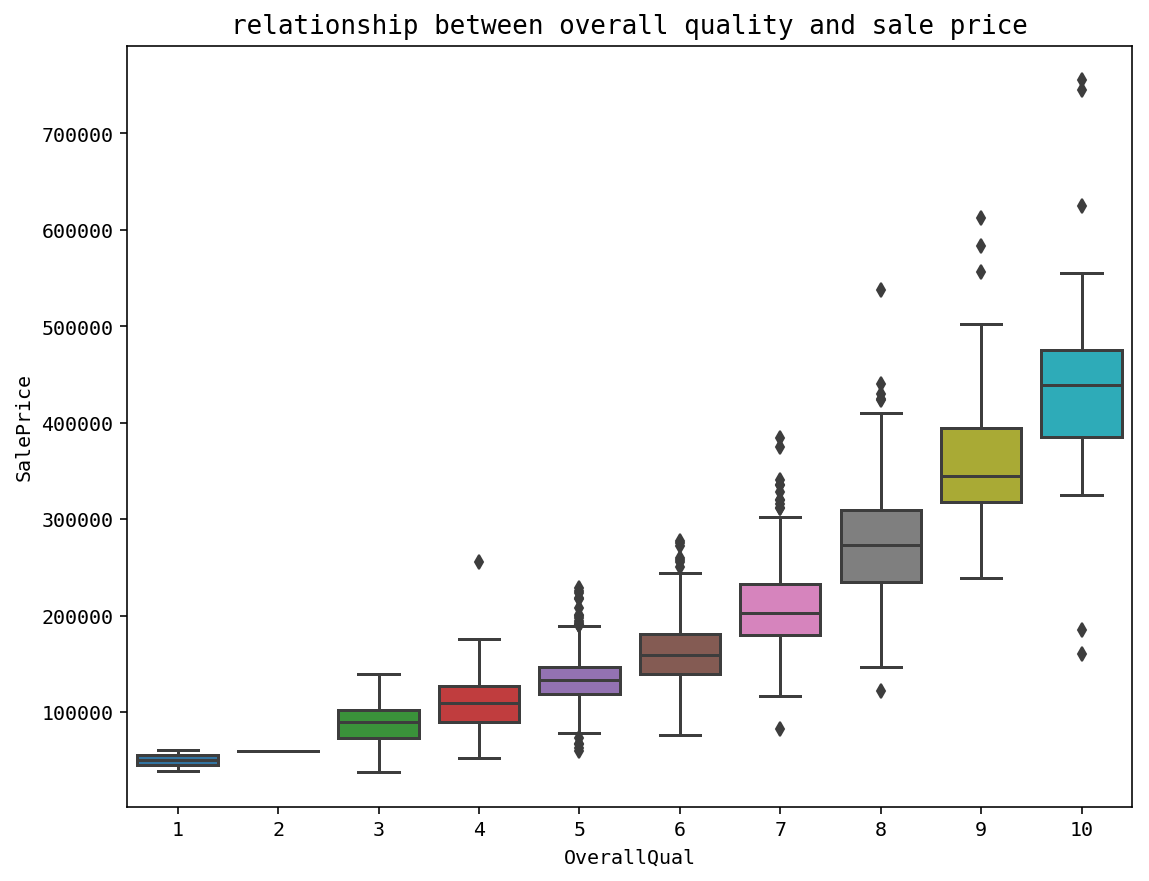

In [20]:
_ = plt.figure(figsize=(9,7))
_ = sns.boxplot('OverallQual', 'SalePrice', data=housenum)
_= plt.title('relationship between overall quality and sale price', size =13)

Observing the above -  

`overall quality` has strong linear correlation to sale price and likely not happen by chance (very low p value). Breaking the `sale price` by `overall quality`, helps us understand that in general, features concerning `area size` influences sale price. For instance, generally houses with higher `overall quality` rating is larger (larger basement area, larger Ground Living Area, etc). And since higher `overall quality` can reflect prices, **we can use area features to predict Sale Price**. We can proceed without `overall quality` but let's keep it for the time being for convenience.

With `age` and `age remodel` there's a trend that younger and recently remodeled houses fetch higher sale price. 

Final features from numerical data:
- BathAbvGr
- Age
- Age_Remodel
- GrLivArea
- TotRmsAbvGrd
- GarageArea
- TotalBsmtSF

In [21]:
f_housenum = housenum[['OverallQual', 'BathAbvGr', 'Age', 'Age_Remodel', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'TotalBsmtSF', 'YrSold']]
f_housenum.shape

(1385, 9)

#### Part 2 - Trim Categorical Data & EDA

In [34]:
housecat = house.select_dtypes('object')
housecat = housecat.join(housenum.SalePrice)

In [23]:
housecat.shape

(1385, 41)

In [24]:
#renov_list = [col for col in housecat.columns if col.contains['Roof', 'Exte', 'Bsmt', 'Heat', 'Fire', 'Garage', 'Elec']]
renov_features = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
       'GarageType', 'GarageFinish']

In [25]:
#Look at our trimmed features
housecat = housecat[housecat.columns[~housecat.columns.isin(renov_features)]]
housecat.shape

(1385, 29)

In [26]:
housecat.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [27]:
#calculate variance - a feature won't have much effect on price if every house on the list has same feature
#so those with low variance (aka majority) can be trimmed. 

def proportion_majority(df, col):
    max_count = df[col].value_counts().max()
    return float(max_count)/df.shape[0]

props = [[col,proportion_majority(housecat, col)] for col in housecat.columns]
props = pd.DataFrame(props, columns=['feature','majority'])
props = props[props.majority > 0.90]
props

feature  majority
2       Street  0.997112
5    Utilities  0.999278
7    LandSlope  0.945848
10  Condition2  0.989892
19  Electrical  0.911913
21  Functional  0.927798
24  GarageCond  0.905415
25  PavedDrive  0.916968

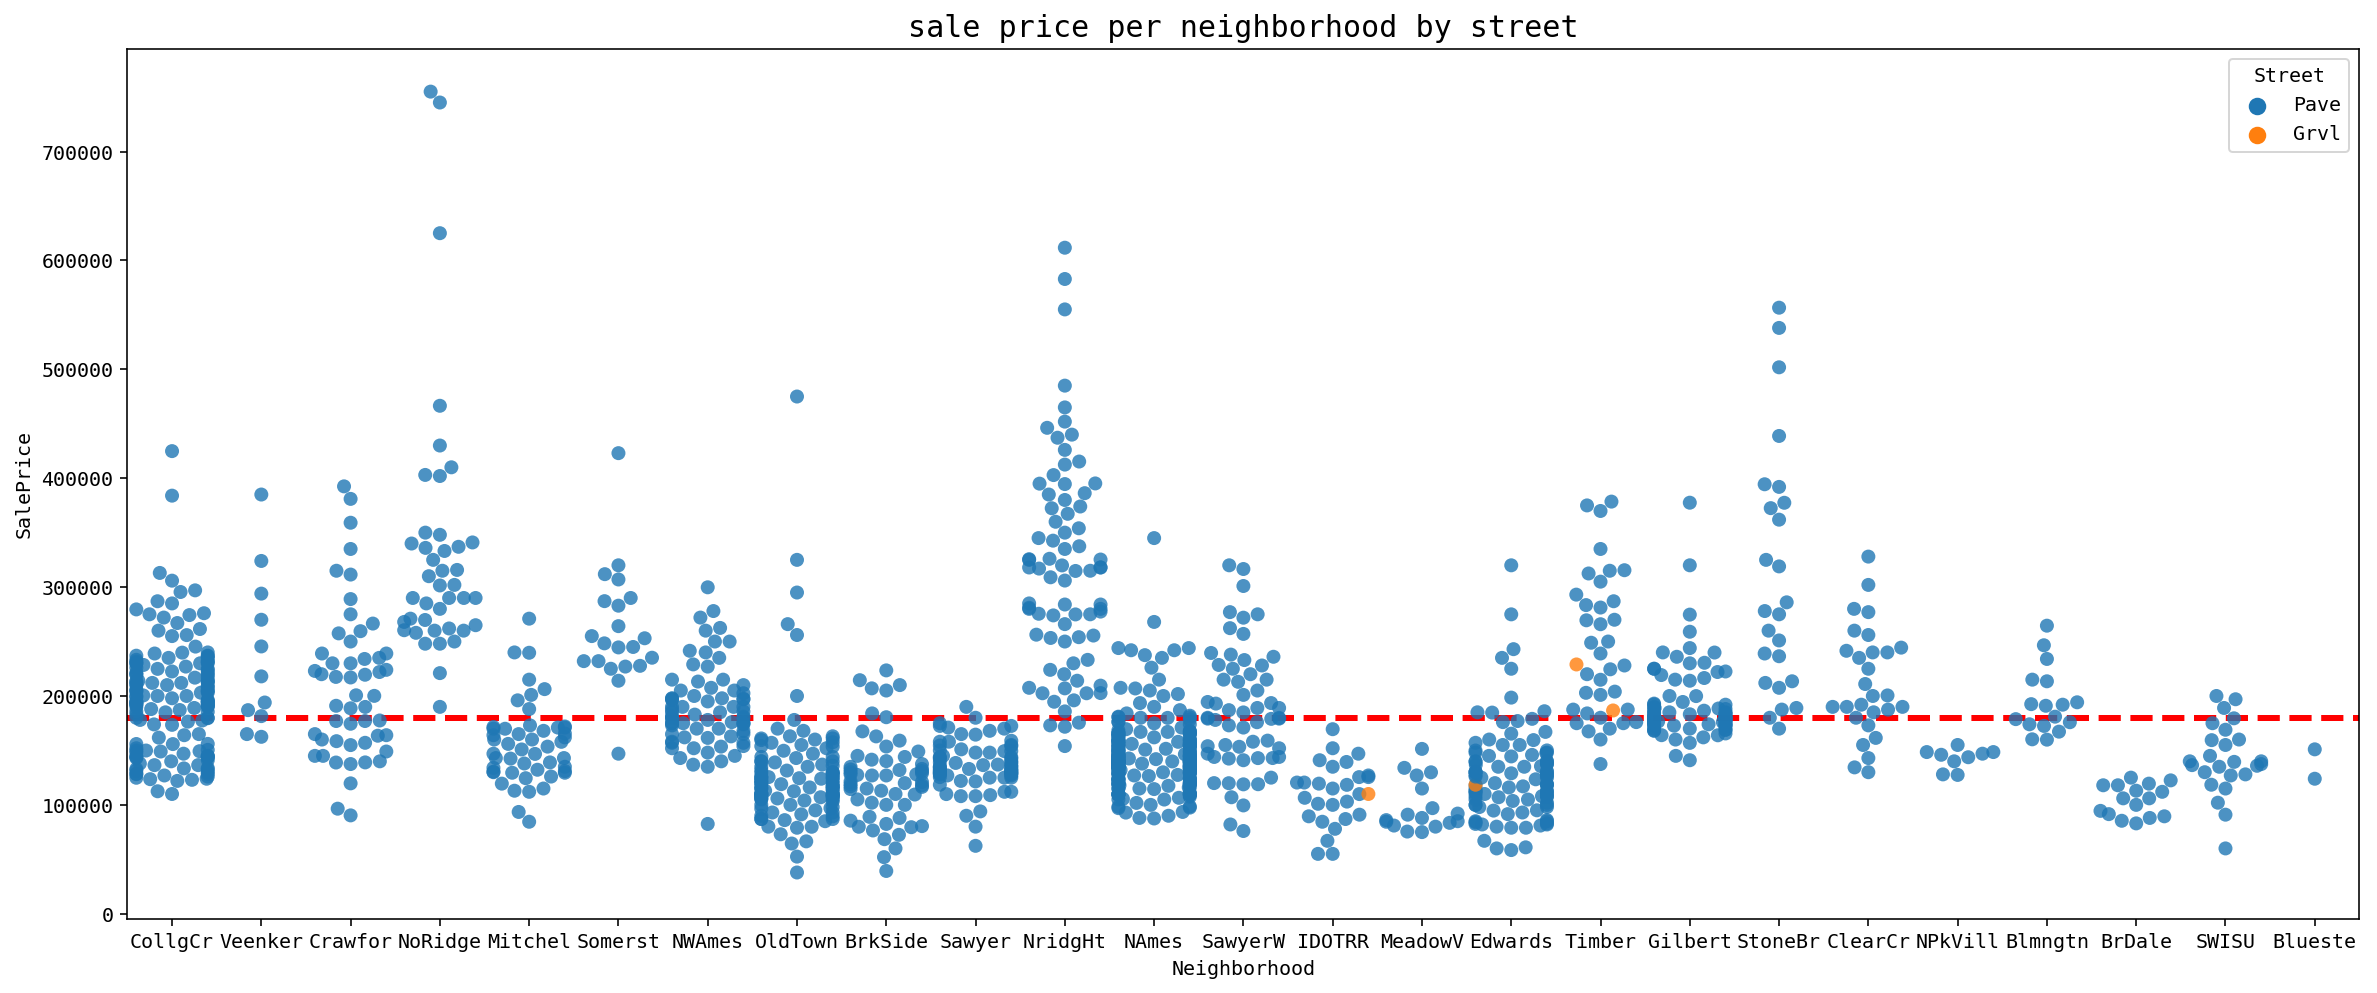

In [28]:
#Just to be sure, plot it
_ = plt.figure(figsize=(20,8))
_ = sns.swarmplot(x="Neighborhood", y="SalePrice", hue="Street", data=housecat, size = 7, alpha=0.8)
_ = plt.title('sale price per neighborhood by street', fontdict = {'fontsize':15} );
_ = plt.axhline(y=np.mean(housecat.SalePrice), color='r', linestyle='--', linewidth = 3)

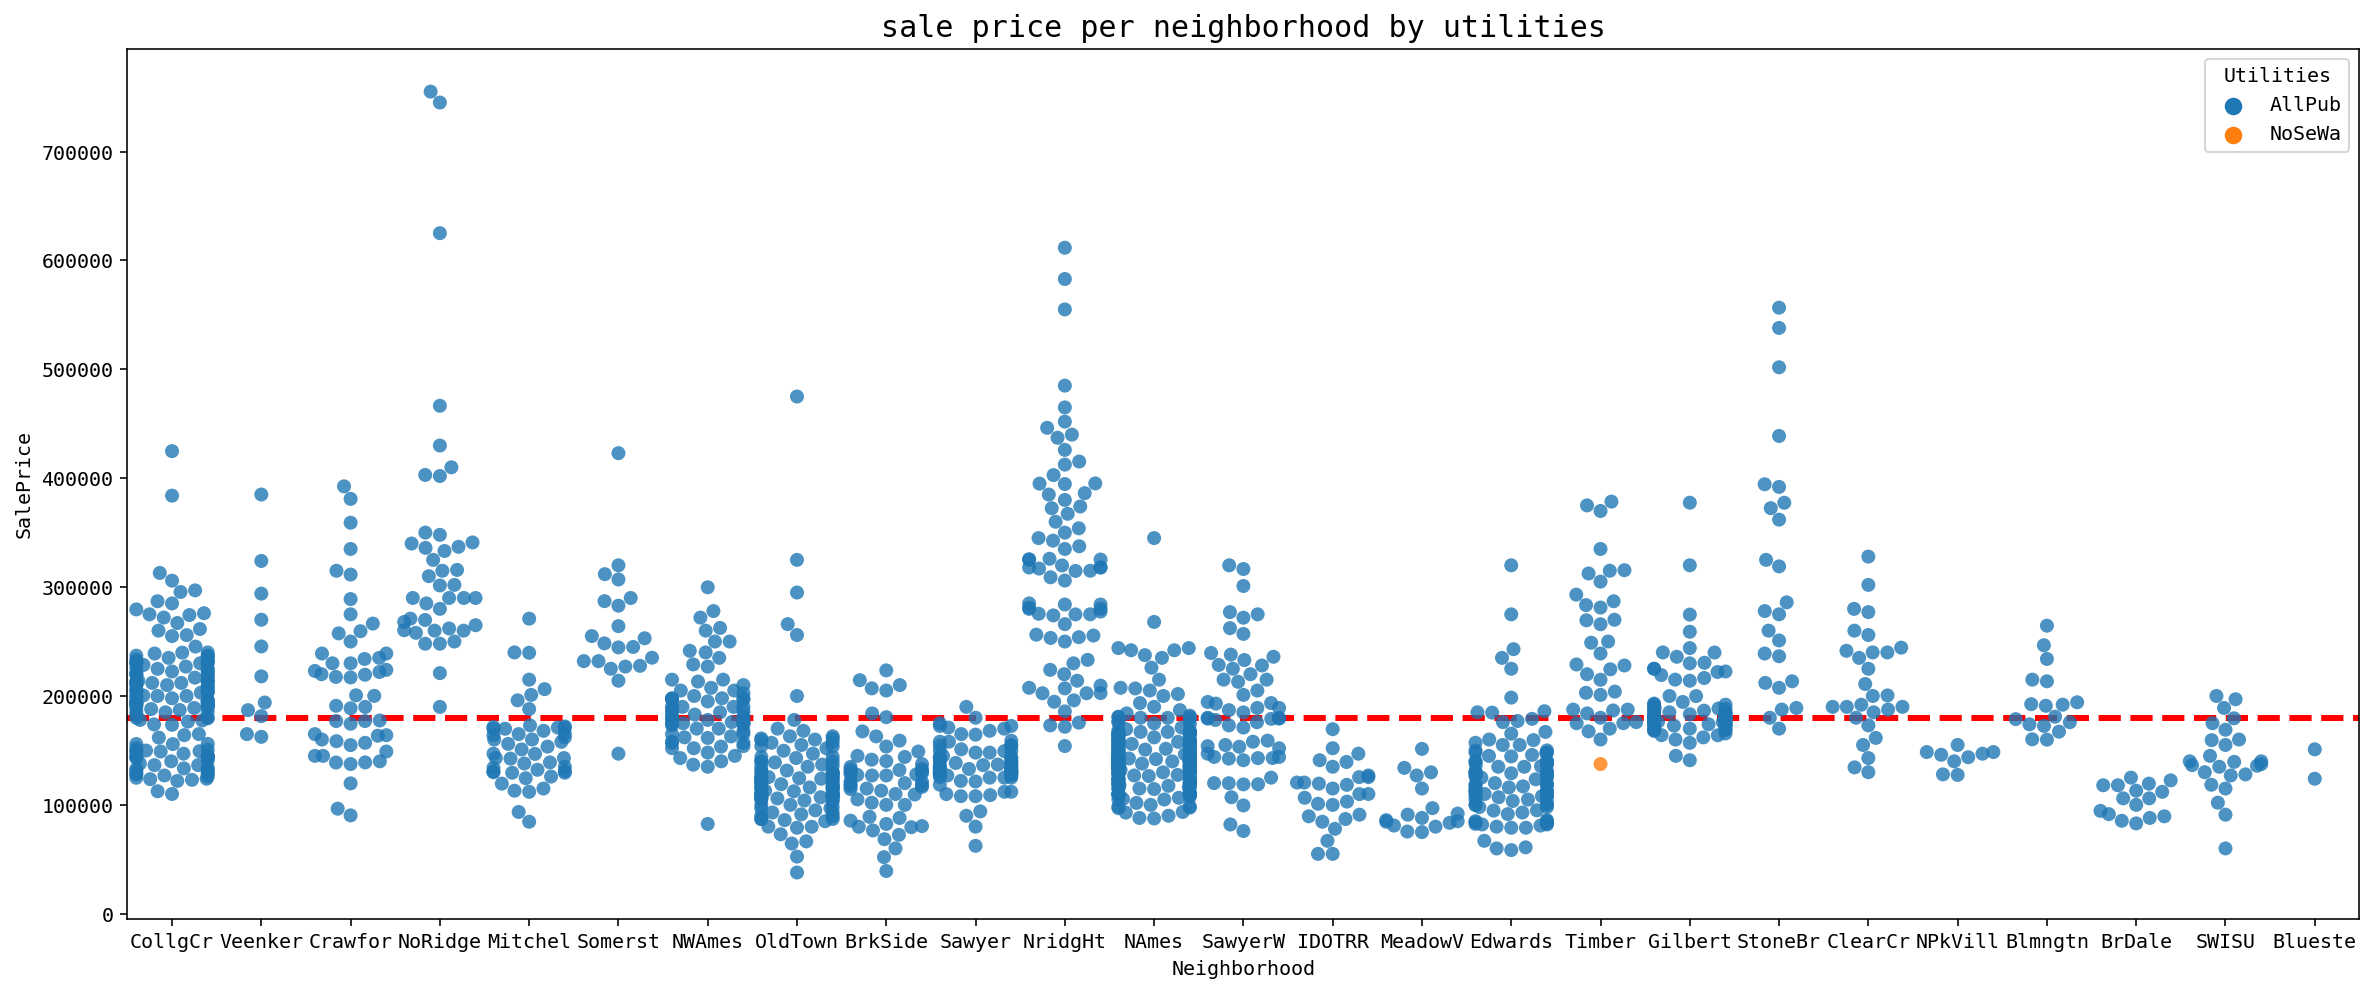

In [29]:
#Just to be sure, plot it
_ = plt.figure(figsize=(20,8))
_ = sns.swarmplot(x="Neighborhood", y="SalePrice", hue="Utilities", data=housecat, size = 7, alpha=0.8)
_ = plt.title('sale price per neighborhood by utilities', fontdict = {'fontsize':15} );
_ = plt.axhline(y=np.mean(housecat.SalePrice), color='r', linestyle='--', linewidth = 3)

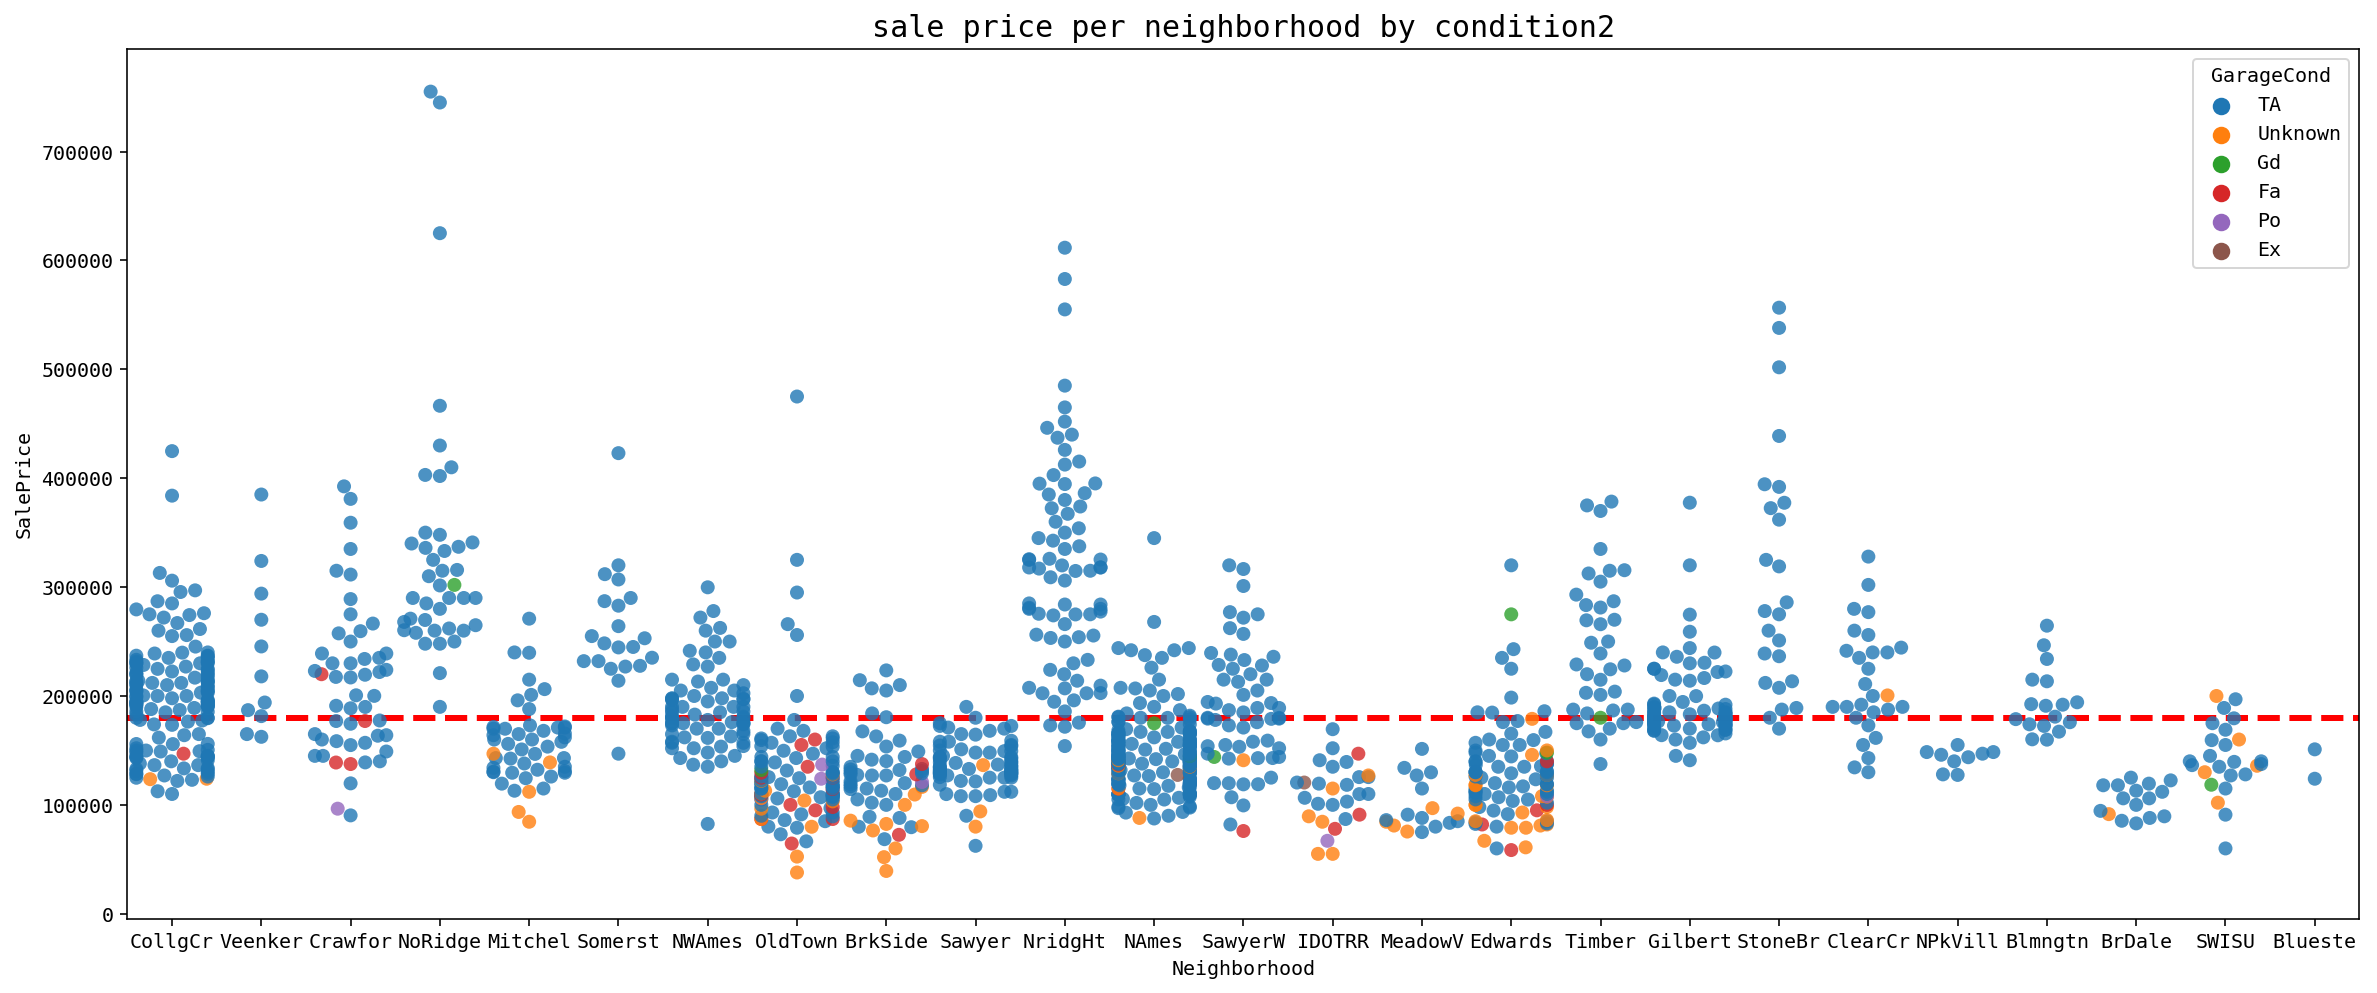

In [30]:
#Just to be sure, plot it
_ = plt.figure(figsize=(20,8))
_ = sns.swarmplot(x="Neighborhood", y="SalePrice", hue="GarageCond", data=housecat, size = 7, alpha=0.8)
_ = plt.title('sale price per neighborhood by condition2', fontdict = {'fontsize':15} );
_ = plt.axhline(y=np.mean(housecat.SalePrice), color='r', linestyle='--', linewidth = 3)

In [31]:
#Drop the blues
features_no_var = [features for features in props.feature]
trim_housecat = housecat.drop(features_no_var, axis=1)

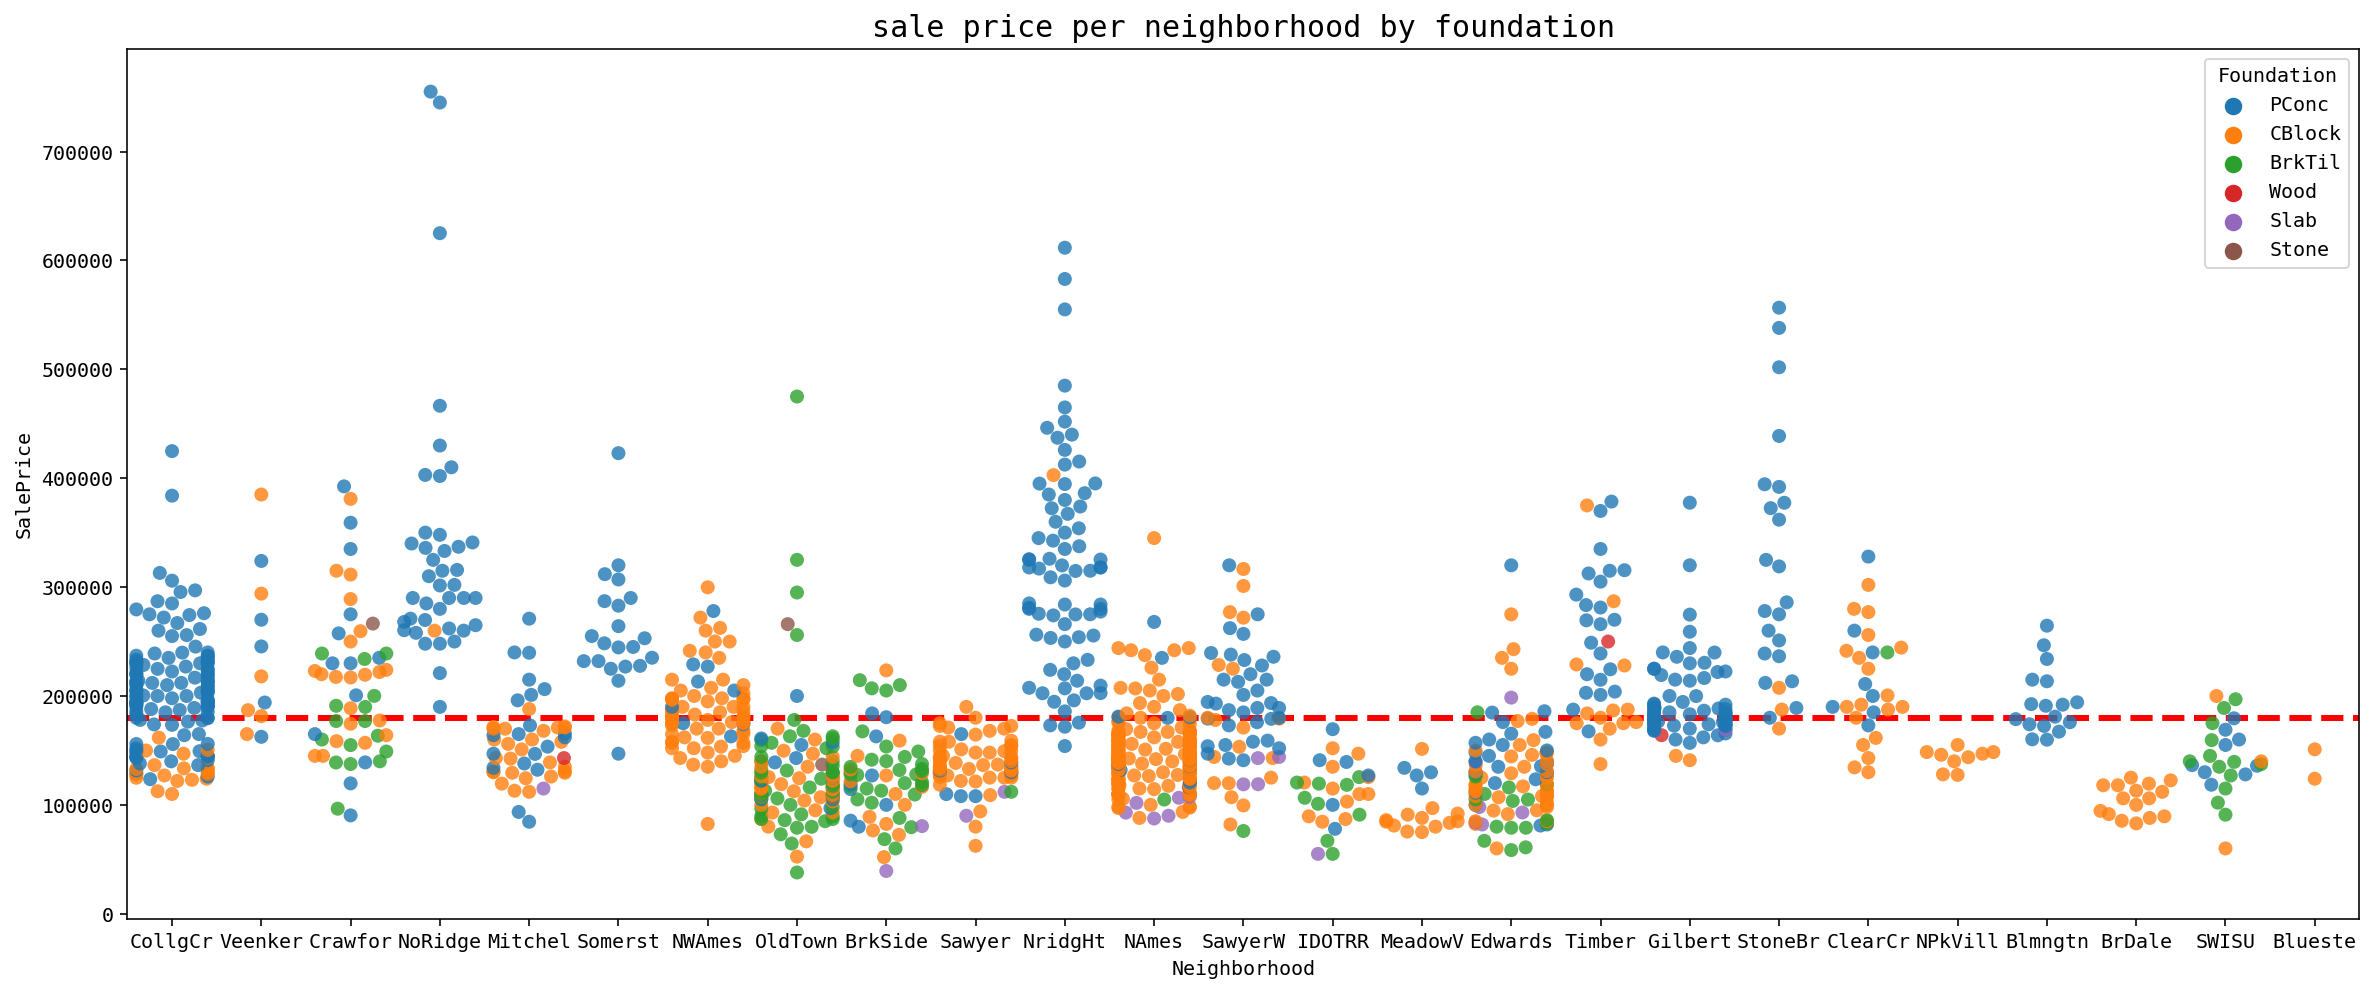

In [32]:
#Features that have strongest influences over price feature are Foundation and Neighbourhood
_ = plt.figure(figsize=(20,8))
_ = sns.swarmplot(x="Neighborhood", y="SalePrice", hue="Foundation", data=housecat, size = 7, alpha=0.8)
_ = plt.title('sale price per neighborhood by foundation', fontdict = {'fontsize':15} );
_ = plt.axhline(y=np.mean(housecat.SalePrice), color='r', linestyle='--', linewidth = 3)

In [33]:
f_housecat = trim_housecat
f_housecat.shape

(1385, 21)

#### Part 3 - Combine Data

In [35]:
df_clean = f_housenum.join(f_housecat)
df_clean.shape

(1385, 30)

In [36]:
df_clean.describe()

OverallQual    BathAbvGr          Age  Age_Remodel    GrLivArea  \
count  1385.000000  1385.000000  1385.000000  1385.000000  1385.000000   
mean      6.063538     1.917690    38.288628    24.215704  1515.031047   
std       1.373366     0.787647    29.871412    20.537893   532.739682   
min       1.000000     0.000000     0.083333    -0.166667   334.000000   
25%       5.000000     1.000000     9.583333     5.416667  1120.000000   
50%       6.000000     2.000000    37.083333    16.333333  1459.000000   
75%       7.000000     2.000000    55.833333    42.416667  1784.000000   
max      10.000000     4.000000   137.000000    60.583333  5642.000000   

       TotRmsAbvGrd   GarageArea  TotalBsmtSF       YrSold      SalePrice  
count   1385.000000  1385.000000  1385.000000  1385.000000    1385.000000  
mean       6.537906   467.954513  1062.618773  2007.810830  180136.283032  
std        1.624029   213.762881   443.785047     1.326813   79906.363281  
min        2.000000     0.000000     0.000000  2006.000000   37900.000000  
25%        5.000000   312.000000   800.000000  2007.000000  129000.000000  
50%        6.000000   472.000000   994.000000  2008.000000  160000.000000  
75%        7.000000   576.000000  1306.000000  2009.000000  212900.000000  
max       14.000000  1418.000000  6110.000000  2010.000000  755000.000000

In [37]:
#Age Remodel has values less than 0, which doesn't makes sense so we can drop that. 
df_clean[df_clean['Age_Remodel'] < 0]

OverallQual  BathAbvGr       Age  Age_Remodel  GrLivArea  TotRmsAbvGrd  \
Id                                                                            
524           10          4  0.833333    -0.166667       4676            11   

     GarageArea  TotalBsmtSF  YrSold MSSubClass    ...    ExterCond  \
Id                                                 ...                
524         884         3138    2007         60    ...           TA   

    Foundation BsmtQual BsmtCond KitchenQual FireplaceQu GarageQual SaleType  \
Id                                                                             
524      PConc       Ex       TA          Ex          Gd         TA      New   

    SaleCondition SalePrice  
Id                           
524       Partial    184750  

[1 rows x 30 columns]

In [38]:
df_clean.drop(df_clean[df_clean.Age_Remodel < 0].index, inplace=True)

### 1.3 Impute

In [39]:
#Check for columns with zero inputs
for c in df_clean.columns:
    if (df_clean[c] == 0).sum() > 0:
        print (c, (df_clean[c] == 0).sum())

BathAbvGr 2
GarageArea 79
TotalBsmtSF 37


**We'll take this approach:**
- for `bath above ground`, we'll impute with feature average
- for `total basement`, since there is no other information, we'll assume the house has no basement
- for `garage area`, since there are no information in the `Garage Cars` we'll impute with linear model between `garage area` and `total basement`

In [40]:
#Look at bath! 
df_clean[df_clean['BathAbvGr'] == 0]

OverallQual  BathAbvGr        Age  Age_Remodel  GrLivArea  TotRmsAbvGrd  \
Id                                                                              
635             6          0  30.500000    30.500000       1056             4   
1214            4          0  41.416667     5.416667        960             3   

      GarageArea  TotalBsmtSF  YrSold MSSubClass    ...    ExterCond  \
Id                                                  ...                
635          576         1056    2010         90    ...           TA   
1214         364          648    2006         80    ...           Gd   

     Foundation BsmtQual BsmtCond KitchenQual FireplaceQu GarageQual SaleType  \
Id                                                                              
635      CBlock       TA       TA          TA     Unknown         TA       WD   
1214     CBlock       TA       Gd          TA     Unknown         TA       WD   

     SaleCondition SalePrice  
Id                            
635         Normal    144000  
1214        Normal    145000  

[2 rows x 30 columns]

In [41]:
df_clean[df_clean['BathAbvGr'] == 0] = df_clean[df_clean['BathAbvGr'] == 0].replace(0, np.median(df_clean['BathAbvGr']))

In [42]:
#Look at garage! 
#First look at values that has strong correlation to Garage, except our target variable
#Since Overall Quality is an aggregate ordinance feature we'll exclude that too
df_clean.corr().GarageArea.sort_values(ascending=False)

GarageArea      1.000000
SalePrice       0.629831
OverallQual     0.564560
TotalBsmtSF     0.502752
GrLivArea       0.472941
BathAbvGr       0.378560
TotRmsAbvGrd    0.337665
YrSold         -0.026275
MSSubClass     -0.109951
Age_Remodel    -0.367317
Age            -0.477041
Name: GarageArea, dtype: float64

In [43]:
df_clean[df_clean['GarageArea'] == 0].loc[:,['GarageArea', 'TotalBsmtSF']].T

Id           40    49    79    90    100   109   126   128   141   149   ...   \
GarageArea      0     0     0     0     0     0     0     0     0     0  ...    
TotalBsmtSF     0   736  1768   990   950   793   520   672   864  1080  ...    

Id           1284  1324  1326  1327  1338  1350  1408  1450  1451  1454  
GarageArea      0     0     0     0     0     0     0     0     0     0  
TotalBsmtSF   912   420   796   544   693   684   833   630   896  1140  

[2 rows x 79 columns]

R2 Score is  0.26759189572035313


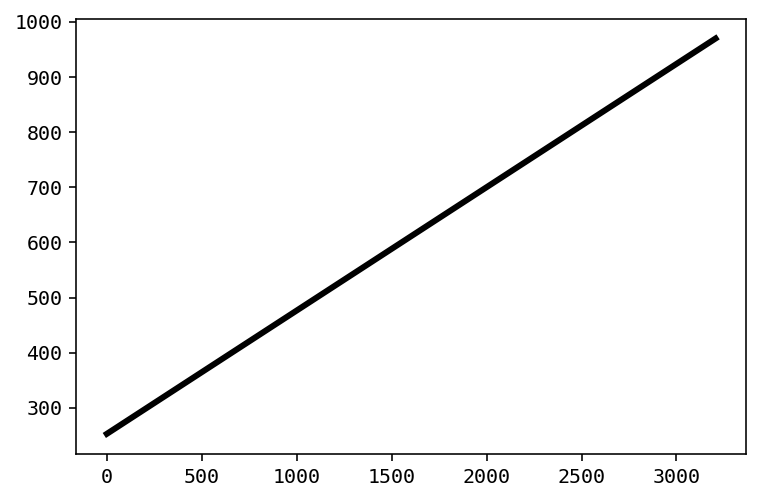

slope is = [[0.22358958]] intercept is = [253.03518458]


In [114]:
#Build Linear Regression Model

lr = LinearRegression()

col = df_clean[df_clean.TotalBsmtSF < 5000]
x = col.TotalBsmtSF.reshape(-1,1)
y = col.GarageArea.reshape(-1,1)

prediction_space = np.linspace(min(x), max(x)).reshape(-1,1)

lr.fit(x, y)

y_pred = lr.predict(prediction_space)

print('R2 Score is ', lr.score(x, y))

# Plot regression line
plt.plot(prediction_space, y_pred, color='black', linewidth=3)
plt.show()

print('slope is =', lr.coef_,  'intercept is =', lr.intercept_)

#I can live with 0.2! 

In [115]:
#Check with polyfit
col = df_clean[df_clean.TotalBsmtSF < 5000]
x = col.TotalBsmtSF
y = col.GarageArea

slope, intercept = np.polyfit(x, y, 1)
print('slope =', slope, 'intercept =', intercept)

slope = 0.2235895790846526 intercept = 253.03518457706417


In [46]:
#function to find garage area

garage = []
def find_garage (x): 
    y = (slope * x) + intercept
    garage.append(y)
    return pd.DataFrame(garage)

bs = df_clean['TotalBsmtSF']
df2 = find_garage(bs)

df_clean.loc[df_clean['GarageArea'] == 0, 'GarageArea'] = df2.T['TotalBsmtSF']

In [47]:
#Check for columns with zero inputs
for c in df_clean.columns:
    if (df_clean[c] == 0).sum() > 0:
        print (c, (df_clean[c] == 0).sum())

TotalBsmtSF 37


### 1.4  Dummies

In [48]:
#Get Dummies for Categorical Variable

def dummy_maker(df):
    cat_dict = {}
    for i in df_clean.columns:
        if len(df_clean[i].value_counts()) < 50 and df[i].dtype == object:
            cat_dict[i] = df[i].value_counts(dropna=False).index
    
    new_df = pd.concat([df, pd.get_dummies(df[list(cat_dict.keys())], dummy_na=True)], axis=1)
    new_df.drop(cat_dict.keys(), axis=1, inplace=True)
    new_df.drop(new_df.loc[:,new_df.sum()==0].columns, axis=1, inplace=True)
        
    return new_df

df_fixed = dummy_maker(df_clean)
df_fixed.head()

OverallQual  BathAbvGr        Age  Age_Remodel  GrLivArea  TotRmsAbvGrd  \
Id                                                                            
1             7          3   5.166667     5.166667       1710             8   
2             6          2  31.416667    31.416667       1262             6   
3             7          3   7.750000     6.750000       1786             6   
4             7          1  91.166667    36.166667       1717             7   
5             8          3   9.000000     9.000000       2198             9   

    GarageArea  TotalBsmtSF  YrSold  MSSubClass          ...            \
Id                                                       ...             
1        548.0          856    2008          60          ...             
2        460.0         1262    2007          20          ...             
3        608.0          920    2008          60          ...             
4        642.0          756    2006          70          ...             
5        836.0         1145    2008          60          ...             

    SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
Id                                                            
1                0             0             0            1   
2                0             0             0            1   
3                0             0             0            1   
4                0             0             0            1   
5                0             0             0            1   

    SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
Id                                                                       
1                       0                      0                     0   
2                       0                      0                     0   
3                       0                      0                     0   
4                       1                      0                     0   
5                       0                      0                     0   

    SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
Id                                                                     
1                      0                     1                      0  
2                      0                     1                      0  
3                      0                     1                      0  
4                      0                     0                      0  
5                      0                     1                      0  

[5 rows x 135 columns]

In [49]:
df_fixed.shape

(1384, 135)

In [50]:
df_fixed.columns

Index(['OverallQual', 'BathAbvGr', 'Age', 'Age_Remodel', 'GrLivArea',
       'TotRmsAbvGrd', 'GarageArea', 'TotalBsmtSF', 'YrSold', 'MSSubClass',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=135)

Text(0.5,0,'Sale Price ($)')

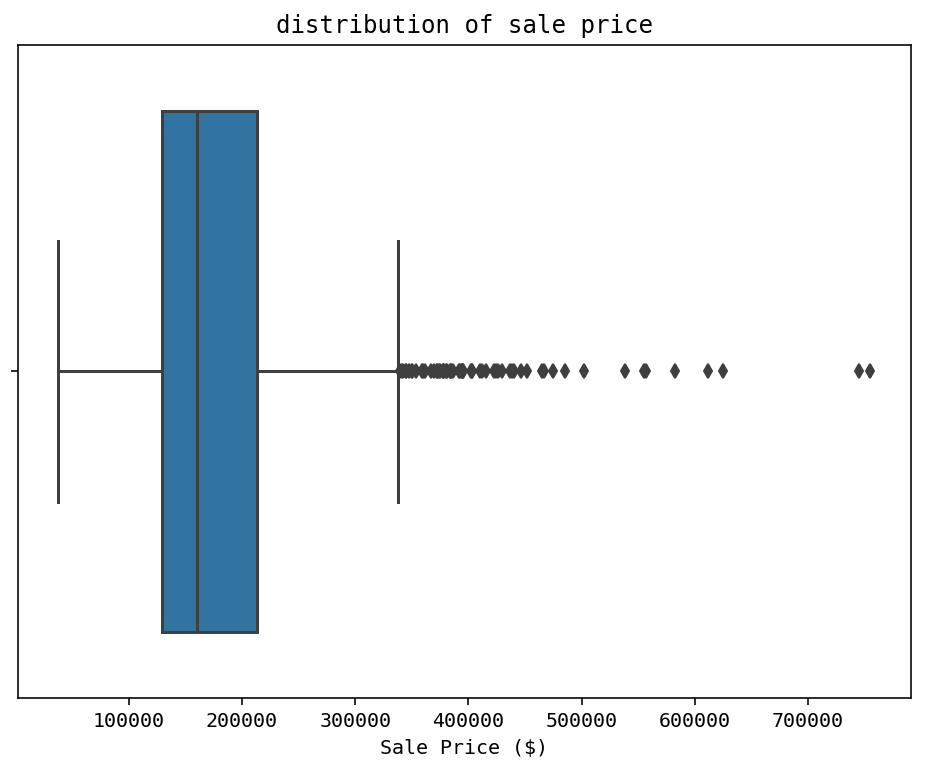

In [51]:
#Remove Outliers
fig1 = plt.figure(figsize=(8,6))
sns.boxplot(df_fixed['SalePrice'])
plt.title('distribution of sale price')
plt.xlabel('Sale Price ($)')

In [52]:
# Out, liars! Many points lie outside of the IQR but two in particular are way off.
df_fixed[df_fixed.SalePrice > 700000].T.head(10)

Id                   692          1183
OverallQual     10.000000    10.000000
BathAbvGr        4.000000     4.000000
Age             13.083333    11.583333
Age_Remodel     12.083333    11.583333
GrLivArea     4316.000000  4476.000000
TotRmsAbvGrd    10.000000    10.000000
GarageArea     832.000000   813.000000
TotalBsmtSF   2444.000000  2396.000000
YrSold        2007.000000  2007.000000
MSSubClass      60.000000    60.000000

Text(0.5,0,'Sale Price ($)')

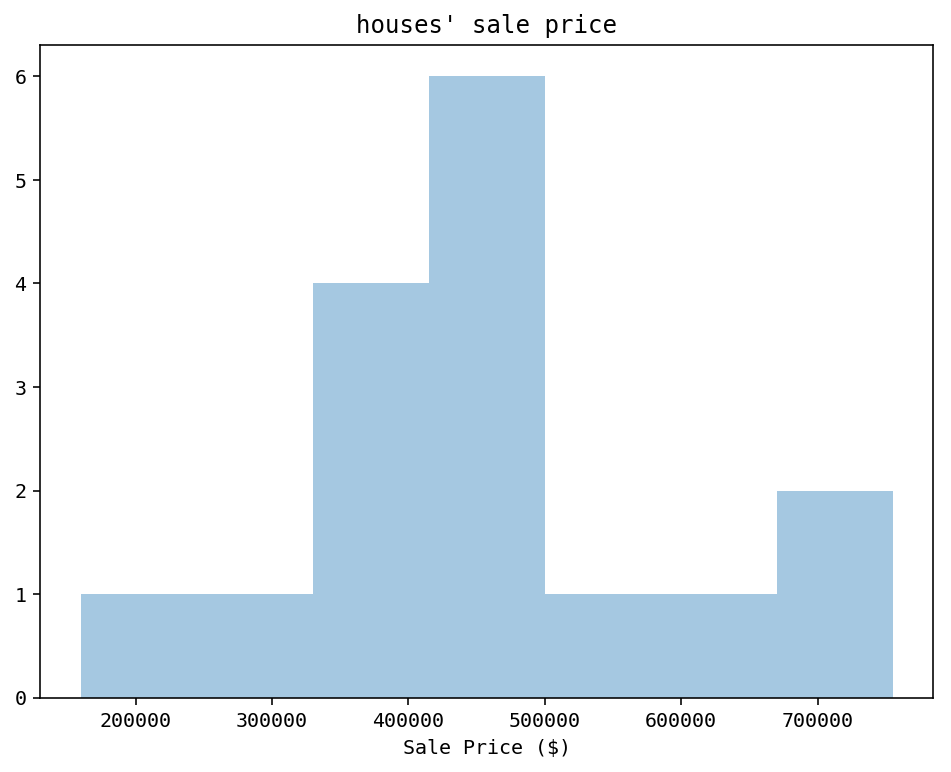

In [53]:
#Let's look at other houses with Overall Quality 10
fig1 = plt.figure(figsize=(8,6))
sns.distplot(df_fixed[df_fixed.OverallQual == 10].SalePrice, kde=False)
plt.title("houses' sale price")
plt.xlabel('Sale Price ($)')

In [54]:
# It seems like most of the other houses fell in the $400-$500k range. 
# Take these two outliars out
df_final = df_fixed[df_fixed.SalePrice < 700000]

### 1.5 Split Data

In [55]:
train = df_final[df_final['YrSold'] != 2010]
test = df_final[df_final['YrSold'] == 2010]

In [56]:
y_train = train['SalePrice']
X_train = train.drop('SalePrice', axis=1)

In [57]:
print(X_train.shape, y_train.shape)

(1218, 134) (1218,)


### 1.6 Scale training set

In [58]:
# Scale all the features on the training set
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)

In [59]:
Xs_train.shape

(1218, 134)

In [60]:
# as scaled data will be in numpy array, cast it back as a df for feature selection
Xs_train_df = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_train_df.head()

OverallQual  BathAbvGr       Age  Age_Remodel  GrLivArea  TotRmsAbvGrd  \
0     0.683809   1.383925 -1.093793    -0.918700   0.384263      0.912858   
1    -0.047428   0.102084 -0.222372     0.357986  -0.485296     -0.330139   
2     0.683809   1.383925 -1.008034    -0.841693   0.531778     -0.330139   
3     0.683809  -1.179756  1.761149     0.589005   0.397850      0.291359   
4     1.415047   1.383925 -0.966538    -0.732263   1.331462      1.534356   

   GarageArea  TotalBsmtSF    YrSold  MSSubClass          ...            \
0    0.300531    -0.460371  0.428032    0.117195          ...             
1   -0.172260     0.461340 -0.460116   -0.870646          ...             
2    0.622889    -0.315077  0.428032    0.117195          ...             
3    0.805558    -0.687393 -1.348265    0.364155          ...             
4    1.847849     0.195724  0.428032    0.117195          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0       -0.064203     -0.287518      -0.04969     0.379028   
1       -0.064203     -0.287518      -0.04969     0.379028   
2       -0.064203     -0.287518      -0.04969     0.379028   
3       -0.064203     -0.287518      -0.04969     0.379028   
4       -0.064203     -0.287518      -0.04969     0.379028   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0              -0.268669              -0.057401             -0.095465   
1              -0.268669              -0.057401             -0.095465   
2              -0.268669              -0.057401             -0.095465   
3               3.722050              -0.057401             -0.095465   
4              -0.268669              -0.057401             -0.095465   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0             -0.122474              0.457748              -0.292509  
1             -0.122474              0.457748              -0.292509  
2             -0.122474              0.457748              -0.292509  
3             -0.122474             -2.184608              -0.292509  
4             -0.122474              0.457748              -0.292509  

[5 rows x 134 columns]

## 2. Feature Selection 

In [61]:
train_cols = list(X_train.columns)

#### Select features with F Classif & Chi2

In [62]:
# Build the selector — f_classif (Scaled Features)
skb_f = SelectKBest(f_classif, k=10)
skb_chi2 = SelectKBest(chi2, k=10)

# Train the selector on the data.
skb_f.fit(Xs_train_df, y_train)
skb_chi2.fit(X_train, y_train)

# Examine the results.
kbest_f = pd.DataFrame([train_cols, list(skb_f.scores_)], 
                     index=['feature','f_classif']).T.sort_values('f_classif', ascending=False)
kbest_f

feature f_classif
121           SaleType_Con       inf
77      MasVnrType_Unknown       inf
130   SaleCondition_Alloca   17.0271
78            ExterQual_Ex   5.81444
125           SaleType_New   5.70978
0              OverallQual   5.18778
42    Neighborhood_NridgHt   5.15141
133  SaleCondition_Partial   5.12676
107         FireplaceQu_Ex   4.54771
41    Neighborhood_NoRidge   3.86368
93             BsmtQual_Ex   3.83438
103         KitchenQual_Ex   3.64775
47    Neighborhood_Somerst   3.43124
100            BsmtCond_Po   3.32027
4                GrLivArea    3.0595
81            ExterQual_TA    2.9217
1                BathAbvGr   2.91013
80            ExterQual_Gd   2.76136
50    Neighborhood_Veenker   2.68048
90         Foundation_Slab   2.62986
6               GarageArea   2.53376
15            LotShape_IR3   2.43583
97        BsmtQual_Unknown   2.22599
102       BsmtCond_Unknown   2.22599
106         KitchenQual_TA   2.19519
105         KitchenQual_Gd    2.1608
76        MasVnrType_Stone   2.12681
7              TotalBsmtSF   2.10159
26    Neighborhood_Blmngtn   2.09596
2                      Age   2.09085
..                     ...       ...
73       MasVnrType_BrkCmn  0.816368
9               MSSubClass  0.793557
52        Condition1_Feedr  0.791369
33    Neighborhood_Edwards  0.786933
108         FireplaceQu_Fa  0.758423
39    Neighborhood_NPkVill    0.7546
40     Neighborhood_NWAmes  0.717335
37    Neighborhood_Mitchel  0.705054
128  SaleCondition_Abnorml  0.653064
44      Neighborhood_SWISU  0.634619
72         HouseStyle_SLvl  0.632019
61         BldgType_2fmCon  0.616771
10             MSZoning_RH  0.611782
45     Neighborhood_Sawyer  0.593195
119           SaleType_COD  0.582307
129  SaleCondition_AdjLand   0.57012
124         SaleType_ConLw  0.561687
30    Neighborhood_ClearCr  0.553353
58         Condition1_RRNe  0.553227
24           LotConfig_FR3  0.550495
82            ExterCond_Ex  0.550495
123         SaleType_ConLI  0.549129
56         Condition1_RRAe  0.493358
54         Condition1_PosA  0.484581
131   SaleCondition_Family  0.476711
120           SaleType_CWD  0.446765
59         Condition1_RRNn  0.406988
27    Neighborhood_Blueste    0.3673
92         Foundation_Wood  0.200935
85            ExterCond_Po       NaN

[134 rows x 2 columns]

In [63]:
f_classif_features = kbest_f['feature'].tolist()
f_classif_features[0:11]

['SaleType_Con',
 'MasVnrType_Unknown',
 'SaleCondition_Alloca',
 'ExterQual_Ex',
 'SaleType_New',
 'OverallQual',
 'Neighborhood_NridgHt',
 'SaleCondition_Partial',
 'FireplaceQu_Ex',
 'Neighborhood_NoRidge',
 'BsmtQual_Ex']

In [64]:
kbest_chi2 = pd.DataFrame([train_cols, list(skb_chi2.scores_)], 
                          index=['feature', 'chi2 score']).T.sort_values('chi2 score', ascending=False)
kbest_chi2.head(50)

feature chi2 score
4                GrLivArea     156927
7              TotalBsmtSF     146096
6               GarageArea    59643.8
2                      Age    18946.1
9               MSSubClass    15073.8
3              Age_Remodel    12957.7
121           SaleType_Con       1217
77      MasVnrType_Unknown       1214
130   SaleCondition_Alloca    1133.18
78            ExterQual_Ex    988.441
107         FireplaceQu_Ex      963.1
42    Neighborhood_NridgHt    945.433
125           SaleType_New    942.005
133  SaleCondition_Partial     922.43
41    Neighborhood_NoRidge    921.466
100            BsmtCond_Po      911.5
47    Neighborhood_Somerst    904.583
103         KitchenQual_Ex    869.583
93             BsmtQual_Ex    867.155
50    Neighborhood_Veenker    853.727
90         Foundation_Slab    841.911
15            LotShape_IR3    830.033
102       BsmtCond_Unknown     791.57
97        BsmtQual_Unknown     791.57
26    Neighborhood_Blmngtn    786.031
68       HouseStyle_2.5Fin    772.281
55         Condition1_PosN     753.53
76        MasVnrType_Stone    733.475
48    Neighborhood_StoneBr    733.202
126           SaleType_Oth      707.5
115          GarageQual_Gd      699.4
116          GarageQual_Po      687.2
49     Neighborhood_Timber    681.645
32    Neighborhood_Crawfor    670.733
122         SaleType_ConLD    653.319
104         KitchenQual_Fa    648.624
18         LandContour_HLS    642.576
66       HouseStyle_1.5Unf    642.168
31    Neighborhood_CollgCr    627.671
34    Neighborhood_Gilbert    624.297
28     Neighborhood_BrDale    623.773
22       LotConfig_CulDSac    619.823
57         Condition1_RRAn    619.437
91        Foundation_Stone     615.15
46    Neighborhood_SawyerW    611.818
99             BsmtCond_Gd    604.585
14            LotShape_IR2    601.805
80            ExterQual_Gd    594.287
118     GarageQual_Unknown    590.124
113          GarageQual_Ex      585.7

In [65]:
chi2_features = kbest_chi2['feature'].tolist()
chi2_features[0:11]

['GrLivArea',
 'TotalBsmtSF',
 'GarageArea',
 'Age',
 'MSSubClass',
 'Age_Remodel',
 'SaleType_Con',
 'MasVnrType_Unknown',
 'SaleCondition_Alloca',
 'ExterQual_Ex',
 'FireplaceQu_Ex']

#### Select using f_regx

In [66]:
from sklearn.feature_selection import f_regression

In [67]:
# Build the selector — f_regression (Scaled Features)
skb_f_regression = SelectKBest(f_regression, k=10)

# Train the selector on the data.
skb_f_regression.fit(Xs_train, y_train)

# Examine the results.
kbest_f_regression = pd.DataFrame([train_cols, list(skb_f_regression.scores_)], 
                                  index=['feature', 'skb_f_regression scores']).T.sort_values('skb_f_regression scores', ascending=False)
kbest_f_regression

feature skb_f_regression scores
0              OverallQual                 2169.96
4                GrLivArea                 1172.88
6               GarageArea                 825.678
81            ExterQual_TA                  722.51
7              TotalBsmtSF                 716.026
1                BathAbvGr                 593.786
93             BsmtQual_Ex                 535.419
106         KitchenQual_TA                 489.481
5             TotRmsAbvGrd                  482.93
2                      Age                 462.705
3              Age_Remodel                 455.154
112    FireplaceQu_Unknown                 391.025
89        Foundation_PConc                 383.412
103         KitchenQual_Ex                 360.869
80            ExterQual_Gd                 356.574
96             BsmtQual_TA                 322.944
42    Neighborhood_NridgHt                 294.547
78            ExterQual_Ex                 292.423
75         MasVnrType_None                 230.116
125           SaleType_New                 212.498
133  SaleCondition_Partial                 203.102
109         FireplaceQu_Gd                 187.273
76        MasVnrType_Stone                 177.691
105         KitchenQual_Gd                 172.086
88       Foundation_CBlock                 142.808
11             MSZoning_RL                 126.773
41    Neighborhood_NoRidge                 120.712
12             MSZoning_RM                 115.592
16            LotShape_Reg                 95.9639
127            SaleType_WD                 87.7634
..                     ...                     ...
20         LandContour_Lvl                 2.19082
113          GarageQual_Ex                  1.9476
56         Condition1_RRAe                 1.87106
126           SaleType_Oth                 1.83305
72         HouseStyle_SLvl                 1.80566
39    Neighborhood_NPkVill                 1.48633
54         Condition1_PosA                  1.4372
123         SaleType_ConLI                 1.22498
84            ExterCond_Gd                 1.18634
8                   YrSold                 1.14033
40     Neighborhood_NWAmes                 1.12688
124         SaleType_ConLw                 1.10181
122         SaleType_ConLD                0.740303
24           LotConfig_FR3                0.710455
69       HouseStyle_2.5Unf                0.676875
26    Neighborhood_Blmngtn                0.670019
27    Neighborhood_Blueste                0.604807
21        LotConfig_Corner                0.555935
64         BldgType_TwnhsE                0.551144
46    Neighborhood_SawyerW                0.490903
108         FireplaceQu_Fa                0.409088
91        Foundation_Stone                0.359621
82            ExterCond_Ex                0.244999
92         Foundation_Wood               0.0989063
57         Condition1_RRAn               0.0496769
120           SaleType_CWD                0.035786
23           LotConfig_FR2               0.0248328
58         Condition1_RRNe              0.00960457
130   SaleCondition_Alloca              0.00763228
85            ExterCond_Po                     NaN

[134 rows x 2 columns]

In [68]:
fregx_features = kbest_f_regression['feature'].tolist()
fregx_features[0:11]

['OverallQual',
 'GrLivArea',
 'GarageArea',
 'ExterQual_TA',
 'TotalBsmtSF',
 'BathAbvGr',
 'BsmtQual_Ex',
 'KitchenQual_TA',
 'TotRmsAbvGrd',
 'Age',
 'Age_Remodel']

#### Using Recursive Feature Elimination (RFE)

In [69]:
from sklearn.feature_selection import RFECV

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(Xs_train, y_train)

print (selector.support_)
print (selector.ranking_)

[False False False False False False False False False False False  True
 False False False False False  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True False False False False False False False
 False  True  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[111 113 120 115 110 119 114 117 118 112   3   1   2  11  12  13  10   1
   1   1   1  48  49  46  50  47  92 102  98  91  85  87  81  84  86  89
 101  96  93  90  99  78  79  88  94 

In [70]:
# The column names correspond to the ones below. (Removed more features than chi2 & f_classif)
rfecv_columns = np.array(train_cols)[selector.support_]
rfecv_columns 

array(['MSZoning_RL', 'LandContour_Bnk', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'BldgType_1Fam',
       'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace',
       'MasVnrType_None', 'MasVnrType_Stone', 'MasVnrType_Unknown'],
      dtype='<U21')

### Lasso 

In [71]:
lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
lasso.fit(X_train, y_train)

print ("Optimal_Alpha: ", lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal_Alpha:  27584.18222277768


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [72]:
lasso.fit(Xs_train, y_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=500, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=1)

In [74]:
lasso_df = pd.DataFrame({'features':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_df.sort_values('abs_coef', inplace=True, ascending=False)

lasso_df

abs_coef          coef               features
4    20350.709909  20350.709909              GrLivArea
0    17361.071532  17361.071532            OverallQual
93    7737.939115   7737.939115            BsmtQual_Ex
41    6967.808425   6967.808425   Neighborhood_NoRidge
6     6097.144785   6097.144785             GarageArea
7     5680.482329   5680.482329            TotalBsmtSF
42    5339.669850   5339.669850   Neighborhood_NridgHt
103   5159.181663   5159.181663         KitchenQual_Ex
48    4436.689812   4436.689812   Neighborhood_StoneBr
3     4229.089868  -4229.089868            Age_Remodel
112   3728.334710  -3728.334710    FireplaceQu_Unknown
60    3649.234978   3649.234978          BldgType_1Fam
32    3458.410226   3458.410226   Neighborhood_Crawfor
2     3383.059736  -3383.059736                    Age
78    2776.370199   2776.370199           ExterQual_Ex
19    2571.038976   2571.038976        LandContour_Low
125   2341.718543   2341.718543           SaleType_New
22    2152.720792   2152.720792      LotConfig_CulDSac
106   2060.087439  -2060.087439         KitchenQual_TA
128   1922.787394  -1922.787394  SaleCondition_Abnorml
14    1814.891719   1814.891719           LotShape_IR2
81    1759.511518  -1759.511518           ExterQual_TA
50    1693.512289   1693.512289   Neighborhood_Veenker
11    1662.811488   1662.811488            MSZoning_RL
98    1472.632455  -1472.632455            BsmtCond_Fa
1     1310.211195   1310.211195              BathAbvGr
43    1233.527359  -1233.527359   Neighborhood_OldTown
9     1171.126801  -1171.126801             MSSubClass
53    1077.718444   1077.718444        Condition1_Norm
33    1051.047605  -1051.047605   Neighborhood_Edwards
..            ...           ...                    ...
13       0.000000      0.000000           LotShape_IR1
10       0.000000     -0.000000            MSZoning_RH
8        0.000000     -0.000000                 YrSold
5        0.000000      0.000000           TotRmsAbvGrd
45       0.000000      0.000000    Neighborhood_Sawyer
46       0.000000      0.000000   Neighborhood_SawyerW
47       0.000000      0.000000   Neighborhood_Somerst
54       0.000000      0.000000        Condition1_PosA
80       0.000000      0.000000           ExterQual_Gd
79       0.000000     -0.000000           ExterQual_Fa
77       0.000000      0.000000     MasVnrType_Unknown
75       0.000000     -0.000000        MasVnrType_None
74       0.000000      0.000000     MasVnrType_BrkFace
73       0.000000     -0.000000      MasVnrType_BrkCmn
72       0.000000      0.000000        HouseStyle_SLvl
71       0.000000      0.000000      HouseStyle_SFoyer
70       0.000000     -0.000000      HouseStyle_2Story
69       0.000000     -0.000000      HouseStyle_2.5Unf
68       0.000000     -0.000000      HouseStyle_2.5Fin
66       0.000000     -0.000000      HouseStyle_1.5Unf
65       0.000000     -0.000000      HouseStyle_1.5Fin
64       0.000000     -0.000000        BldgType_TwnhsE
62       0.000000     -0.000000        BldgType_Duplex
61       0.000000      0.000000        BldgType_2fmCon
59       0.000000     -0.000000        Condition1_RRNn
58       0.000000      0.000000        Condition1_RRNe
57       0.000000      0.000000        Condition1_RRAn
56       0.000000     -0.000000        Condition1_RRAe
55       0.000000      0.000000        Condition1_PosN
133      0.000000      0.000000  SaleCondition_Partial

[134 rows x 3 columns]

In [75]:
lasso_features = lasso_df['features'].tolist()
lasso_features[0:11]

['GrLivArea',
 'OverallQual',
 'BsmtQual_Ex',
 'Neighborhood_NoRidge',
 'GarageArea',
 'TotalBsmtSF',
 'Neighborhood_NridgHt',
 'KitchenQual_Ex',
 'Neighborhood_StoneBr',
 'Age_Remodel',
 'FireplaceQu_Unknown']

Observations - 

Some features are shared amongst the methods, i.e. lasso, regx and chi2

rfecv and f_classif are just weird and I'm not sure why.

worth mentioning here that, only chi2 didn't select `overall quality`, which is colinear with other area features.

We can test to see how they perform and select the best model, hopefully that'll make more sense!

## 3. Model Selection 

In [76]:
test_cols = list(X_train.columns)

y_test = test['SalePrice']
X_test = test.drop('SalePrice', axis=1)

### Step 1 -  Building predictor on all models

In [77]:
#Building Predictors with various models

#F_classif
X_train_fclassif = X_train[f_classif_features[:11]]
X_test_fclassif = X_test[f_classif_features[:11]]

#Chi2
X_train_chi2 = X_train[chi2_features[:11]]
X_test_chi2 = X_test[chi2_features[:11]]

#RFECV
X_train_rfecv = X_train[rfecv_columns]
X_test_rfecv = X_test[rfecv_columns]

#F_regression
X_train_fregx = X_train[fregx_features[:11]]
X_test_fregx = X_test[fregx_features[:11]]

#Lasso
X_train_lasso = X_train[lasso_features[:11]]
X_test_lasso = X_test[lasso_features[:11]]

### Step 2 -  Scale the predictors

In [78]:
ss = StandardScaler()

Xs_train_fclassif = ss.fit_transform(X_train_fclassif)
Xs_test_fclassif = ss.fit_transform(X_test_fclassif)

Xs_train_chi2 = ss.fit_transform(X_train_chi2)
Xs_test_chi2 = ss.fit_transform(X_test_chi2)

Xs_train_rfecv = ss.fit_transform(X_train_rfecv)
Xs_test_rfecv = ss.fit_transform(X_test_rfecv)

Xs_train_fregx = ss.fit_transform(X_train_fregx)
Xs_test_fregx = ss.fit_transform(X_test_fregx)

Xs_train_lasso = ss.fit_transform(X_train_lasso)
Xs_test_lasso = ss.fit_transform(X_test_lasso)

### Step 3 -  Cross-Validate Model on Linear Regression

In [79]:
#Test the Model on Linear Regression

# f_classif Model

# initiate the Linear Regression (LR) Model
lr_f_classif = LinearRegression()

# train the LR model from the variables in the train test split
lr_f_classif.fit(Xs_train_fclassif, y_train)

# do a 10 fold cross validation on the training set
lr_f_classif_cvs = cross_val_score(lr_f_classif, Xs_train_fclassif, y_train, cv=10)

# perform prediction on the testing set
predictions_f_classif = lr_f_classif.predict(Xs_test_fclassif)

f_classif_R2 = metrics.r2_score(y_test, predictions_f_classif)

In [80]:
# Chi2 Model

# initiate the Linear Regression (LR) Model
lr_chi2 = LinearRegression()

# train the LR model from the variables in the train test split
lr_chi2.fit(Xs_train_chi2, y_train)

# do a 10 fold cross validation on the training set
lr_chi2_cvs = cross_val_score(lr_chi2, Xs_train_chi2, y_train, cv=10)

# perform prediction on the testing set
predictions_chi2 = lr_chi2.predict(Xs_test_chi2)
chi2_R2 = metrics.r2_score(y_test, predictions_chi2)

In [81]:
# RFECV Model

# initiate the Linear Regression (LR) Model
lr_re = LinearRegression()

# train the LR model from the variables in the train test split
lr_re.fit(Xs_train_rfecv, y_train)

# do a 10 fold cross validation on the training set
lr_re_cvs = cross_val_score(lr_re, Xs_train_rfecv, y_train, cv=10)

# perform prediction on the testing set
predictions_re = lr_re.predict(Xs_test_rfecv)
re_R2 = metrics.r2_score(y_test, predictions_re)

In [82]:
# F_regression Model

# initiate the Linear Regression (LR) Model
lr_fregx = LinearRegression()

# train the LR model from the variables in the train test split
lr_fregx.fit(Xs_train_fregx, y_train)

# do a 10 fold cross validation on the training set
lr_fregx_cvs = cross_val_score(lr_fregx, Xs_train_fregx, y_train, cv=10)

# perform prediction on the testing set
predictions_fregx = lr_fregx.predict(Xs_test_fregx)
fregx_R2 = metrics.r2_score(y_test, predictions_fregx)

In [83]:
# Lasso Model

# initiate the Linear Regression (LR) Model
lr_lasso = LinearRegression()

# train the LR model from the variables in the train test split
lr_lasso.fit(Xs_train_lasso, y_train)

# do a 10 fold cross validation on the training set
lr_lasso_cvs = cross_val_score(lr_lasso, Xs_train_lasso, y_train, cv=10)

# perform prediction on the testing set
predictions_lasso = lr_lasso.predict(Xs_test_lasso)
lasso_R2 = metrics.r2_score(y_test, predictions_lasso)

### Step 4 -  Compare Models

#### Compre Squared Error

In [84]:
#F Classif
print ("F_classif model - R2 scores on train data: ", np.mean(lr_f_classif_cvs))
print ("F_classif model - R2 scores on test data: " , f_classif_R2)

F_classif model - R2 scores on train data:  0.710879555427575
F_classif model - R2 scores on test data:  0.705102465510709


In [85]:
#Chi2
print ("Chi2 model - R2 scores on train data: ", np.mean(lr_chi2_cvs))
print ("Chi2 model - R2 scores on test data: " , chi2_R2)

Chi2 model - R2 scores on train data:  0.7362483552908539
Chi2 model - R2 scores on test data:  0.8332275635647393


In [86]:
#RFECV
print ("RFECV model - R2 scores on train data: ", np.mean(lr_re_cvs))
print ("RFECV model - R2 scores on test data: " , re_R2)

RFECV model - R2 scores on train data:  0.30592917022478666
RFECV model - R2 scores on test data:  -1.1566657047941695e+25


In [87]:
#F Regression
print ("F Regression model - R2 scores on train data: ", np.mean(lr_fregx_cvs))
print ("F Regression model - R2 scores on test data: " , fregx_R2)

F Regression model - R2 scores on train data:  0.7832635084894273
F Regression model - R2 scores on test data:  0.8149599205535477


In [88]:
#Lasso
print ("Lasso model - R2 scores on train data: ", np.mean(lr_lasso_cvs))
print ("Lasso model - R2 scores on test data: " , lasso_R2)

Lasso model - R2 scores on train data:  0.8043021228503642
Lasso model - R2 scores on test data:  0.8397871298034045


Observation:

From the tests above, seems like Lasso, F Regression and Chi2 perform equally well. Let's plot them

### Step 5 - Plot

In [89]:
# baseline of the house price
baseline = y_train.mean()
print ("House Baseline is ", baseline)

House Baseline is  179508.52052545155


#### F Regression

In [90]:
# coefficient dataframe (cdf)
print ('Intercept: ', lr_fregx.intercept_)
cdf = pd.DataFrame(lr_fregx.coef_, X_test_fregx.columns, columns=['Coeff'])
print (cdf.sort_values(by='Coeff', ascending=False))

Intercept:  179508.52052545155
                       Coeff
GrLivArea       24868.109644
OverallQual     22408.273108
BsmtQual_Ex     12843.769384
TotalBsmtSF      7956.637389
GarageArea       7847.885935
BathAbvGr         723.988723
TotRmsAbvGrd    -1263.005733
ExterQual_TA    -3049.876817
Age_Remodel     -3457.764672
KitchenQual_TA  -3890.331926
Age             -6848.214466


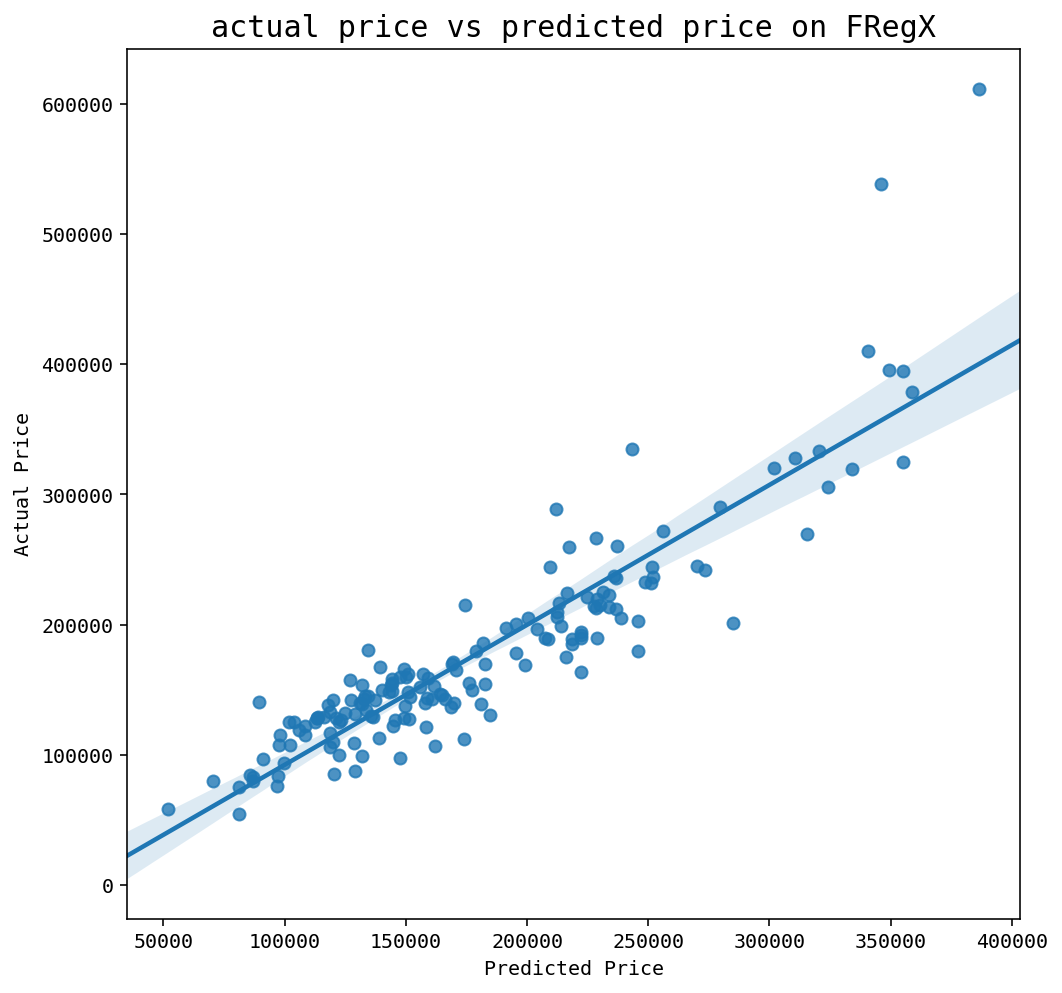

In [91]:
fig = plt.figure(figsize=(8,8))
sns.regplot(predictions_fregx, y_test)
plt.title("actual price vs predicted price on FRegX", fontsize=15)
plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.show()

#### Chi2

In [92]:
# coefficient dataframe (cdf)
print ('Intercept: ', lr_chi2.intercept_)
cdf = pd.DataFrame(lr_chi2.coef_, X_test_chi2.columns, columns=['Coeff'])
print (cdf.sort_values(by='Coeff', ascending=False))

Intercept:  179508.52052545155
                             Coeff
GrLivArea             35389.809378
ExterQual_Ex          12916.735050
TotalBsmtSF            9474.811343
GarageArea             9329.236128
FireplaceQu_Ex         4223.369582
SaleType_Con           3260.505225
MasVnrType_Unknown      474.171793
SaleCondition_Alloca   -784.569158
MSSubClass            -6703.659270
Age_Remodel          -10698.712341
Age                  -16477.680585


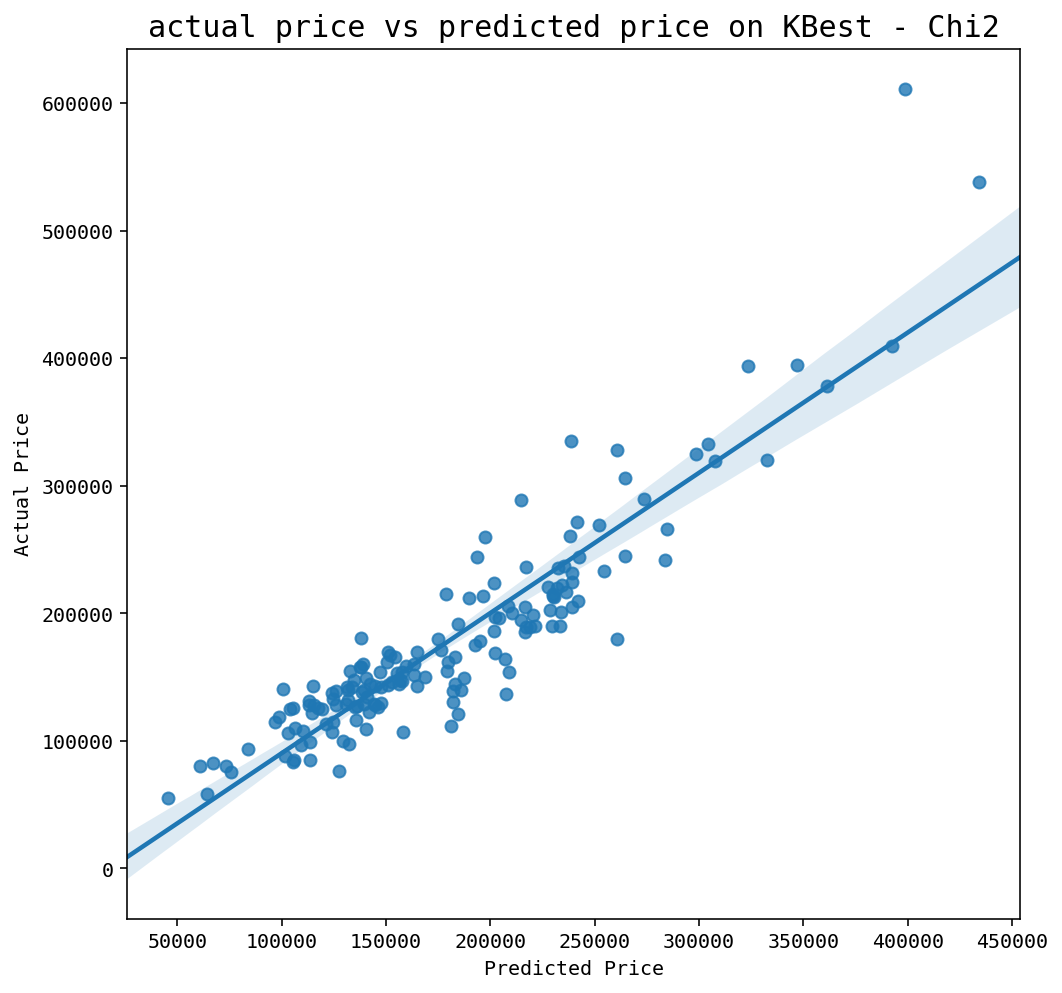

In [93]:
fig = plt.figure(figsize=(8,8))
sns.regplot(predictions_chi2, y_test)
plt.title("actual price vs predicted price on KBest - Chi2", fontsize=15)
plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.show()

#### Lasso

In [94]:
# coefficient dataframe (cdf)
print ('Intercept: ', lr_lasso.intercept_)
cdf = pd.DataFrame(lr_lasso.coef_, X_test_lasso.columns, columns=['Coeff'])
print (cdf.sort_values(by='Coeff', ascending=False))

Intercept:  179508.52052545155
                             Coeff
OverallQual           20577.942845
GrLivArea             19231.524565
BsmtQual_Ex            9636.853413
GarageArea             8519.752219
Neighborhood_NoRidge   8332.857666
TotalBsmtSF            7993.693235
Neighborhood_StoneBr   5656.588711
KitchenQual_Ex         5653.260111
Neighborhood_NridgHt   5645.460131
FireplaceQu_Unknown   -7331.017356
Age_Remodel           -9025.433597


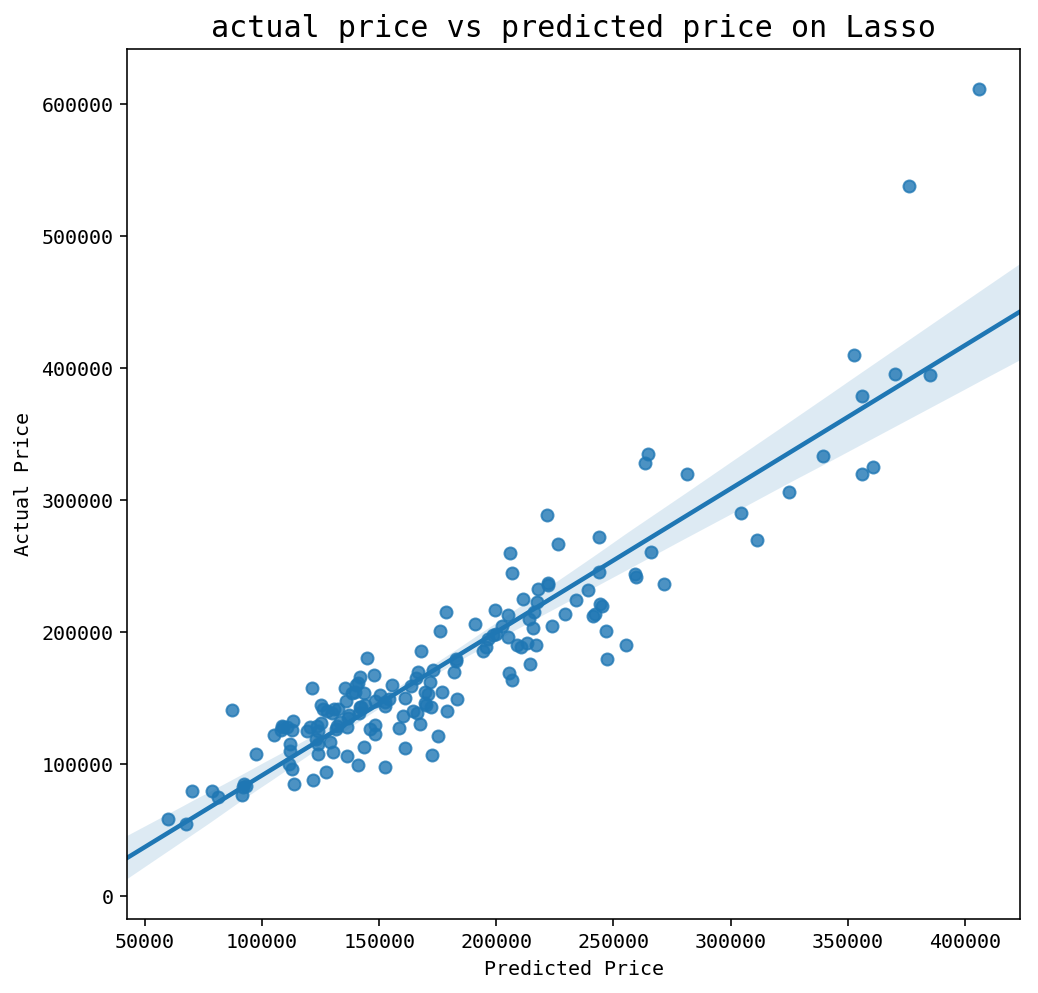

In [95]:
fig = plt.figure(figsize=(8,8))
sns.regplot(predictions_lasso, y_test)
plt.title("actual price vs predicted price on Lasso", fontsize=15)
plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.show()

**Observation**
From the plots above, seems like Chi2 is the best model, it fits the dots better

In [96]:
# Regression evaluation matrix on Chi2 Model
mse_chi2 = metrics.mean_squared_error(y_test, predictions_chi2) #MSE
print ("Chi2 Model MSE on testing set: ", mse_chi2)
rmse_chi2 = np.sqrt(metrics.mean_squared_error(y_test, predictions_chi2)) #RMSE
print ("Chi2 Model RMSE on testing set: ", rmse_chi2)

Chi2 Model MSE on testing set:  1092792333.389904
Chi2 Model RMSE on testing set:  33057.409659407735


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [230]:
#Get Dummies, Remove Outliers
reno = pd.get_dummies(house[renov_features], drop_first=True)

merge = reno.join(df_fixed.YrSold)
merge = merge.join(df_fixed.SalePrice)
merge = merge.dropna()
merge_final = merge[merge.SalePrice < 700000]

In [238]:
#Chi2
chi2_cond_features = [i for i in chi2_features if 'Cond' in i]
chi2_quality_features = [i for i in chi2_features if 'Qu' in i]
chi2_join_features = df_fixed[chi2_cond_features + chi2_quality_features]
chi2_df_merge = chi2_join_features.join(merge_final, how='outer')
chi2_df_merge = chi2_df_merge.dropna()
chi2_df_merge.columns

Index(['SaleCondition_Alloca', 'SaleCondition_Partial', 'BsmtCond_Po',
       'BsmtCond_Unknown', 'Condition1_PosN', 'Condition1_RRAn', 'BsmtCond_Gd',
       'ExterCond_Fa', 'BsmtCond_Fa', 'Condition1_Artery',
       ...
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
       'GarageType_Detchd', 'GarageType_Unknown', 'GarageFinish_RFn',
       'GarageFinish_Unf', 'GarageFinish_Unknown', 'YrSold', 'SalePrice'],
      dtype='object', length=129)

In [232]:
#Split the Chi2 Dataset
chi2_reno_train = chi2_df_merge[chi2_df_merge['YrSold'] != 2010]
chi2_reno_test = chi2_df_merge[chi2_df_merge['YrSold'] == 2010]

In [233]:
#Chi2
chi2_reno_train_y = chi2_reno_train['SalePrice']
chi2_reno_train_X = chi2_reno_train.drop('SalePrice', axis=1)

chi2_reno_test_y = chi2_reno_test['SalePrice']
chi2_reno_test_X = chi2_reno_test.drop('SalePrice', axis=1)

In [234]:
chi2_reno_train_Xs = StandardScaler().fit_transform(chi2_reno_train_X)
chi2_reno_test_Xs = StandardScaler().fit_transform(chi2_reno_test_X)

In [235]:
# initiate the Linear Regression (LR) Model
lr_chi2_reno = LinearRegression()

# train the LR model from the variables in the train test split
lr_chi2_reno.fit(chi2_reno_train_Xs, chi2_reno_train_y)

# do a 10 fold cross validation on the training set
lr_chi2_reno_cvs = cross_val_score(lr_chi2_reno, chi2_reno_train_Xs, chi2_reno_train_y, cv=10)

# perform prediction on the testing set
predictions_chi2_reno = lr_chi2_reno.predict(chi2_reno_test_Xs)
chi2_R2_reno = metrics.r2_score(chi2_reno_test_y, predictions_chi2_reno)

In [239]:
# Regression evaluation matrix on fixed fixture
mse_chi2 = metrics.mean_squared_error(y_test, predictions_chi2) #MSE
print ("Chi2 Model MSE on testing set: ", mse_chi2)
rmse_chi2 = np.sqrt(metrics.mean_squared_error(y_test, predictions_chi2)) #RMSE
print ("Chi2 Model RMSE on testing set: ", rmse_chi2)

Chi2 Model MSE on testing set:  1092792333.389904
Chi2 Model RMSE on testing set:  33057.409659407735


In [243]:
# Regression evaluation matrix on renovatable fixture
mse_chi2_reno = metrics.mean_squared_error(chi2_reno_test_y, predictions_chi2_reno) #MSE
print ("Chi2 Model MSE on reno testing set: ", mse_chi2_reno)
rmse_chi2_reno = np.sqrt(metrics.mean_squared_error(chi2_reno_test_y, predictions_chi2_reno)) #RMSE
print ("Chi2 Model RMSE on reno testing set: ", rmse_chi2_reno)

Chi2 Model MSE on reno testing set:  1.9614523081179425e+34
Chi2 Model RMSE on reno testing set:  1.4005185854239645e+17


In [248]:
# Calculate the difference of the residuals for the price with renovate-able features against 
# price using only the fixed features.
rmse_chi2_reno - rmse_chi2

# the RMSE scores between the 2 model seems to indicate that there is no effect with 
# the renovate-able features added in. (reduction of $0 in price error.)

#Bad model!!!

0.0

In [254]:
test_price_fixed = pd.DataFrame(predictions_chi2, columns=['Price_fixed'])
test_price_reg_reno = pd.DataFrame(predictions_chi2_reno, columns=['Price_Reno'])

test_y_reset = y_test.reset_index()
test_price = test_y_reset.drop('Id', axis=1)

price_compare = pd.concat([test_price, test_price_fixed, test_price_reg_reno], axis=1)
price_compare.head()

SalePrice    Price_fixed    Price_Reno
0     149000  140174.519423  1.334506e+16
1     154000  147323.348210  1.539512e+16
2     134800  140869.251212  1.335968e+16
3     306000  264553.898716  2.832417e+16
4     165500  182976.400059  1.170203e+16

In [1]:
#Something is very wrong... not sure I understand the question correctly, or use the correct variables.
#And if you see this message that means I haven't fixed it
#In any case, I'll continue working on this over the weekend

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: